<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/04-modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem Preditiva com Modelos Baseados em Contagem

Esse notebook tem como objetivo analisar os dados transacionais agrupados, em janelas de 15 minutos, e avaliar as caracteristicas que podem influênciar na quantidade de contagem de fraudes.

## 1. Importação de bibliotecas e Dados

In [125]:
%pip install statstests

In [126]:
# Bibliotecas para Análise
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
from matplotlib import pyplot as plt

# Bibliotecas para StepWise
from tqdm import tqdm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin

# Bibliotecas para Modelagem
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statstests.tests import overdisp
from scipy.stats import poisson, nbinom
from statstests.process import stepwise
from statsmodels.iolib.summary2 import summary_col
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

filterwarnings('ignore')

In [127]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/transactions_features.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
df = pd.read_parquet('/content/datasets/transactions_features.parquet')

## 2. Análise e Modelagem Preditiva com Modelos de Contagem

In [129]:
df.head(10)

,date_window,frauds,total_amount,mean_amount,max_amount,mean_current_age,max_current_age,min_current_age,mean_per_capita_income,max_per_capita_income,...,category_arts_entertainment_recreation,category_professional_business_services,category_food_beverage,category_technology_telecommunications,category_sports_recreation,category_retail_home_garden,category_construction_contractors,category_manufacturing_industrial,category_personal_services,previous_frauds
0,2010-01-01 00:00:00,0,2933.33,41.904714,270.22,53.771429,101,30,23602.442857,55362.0,...,0.01,0.01,0.43,0.01,0.00,0.00,0.0,0.00,0.00,0
1,2010-01-01 03:00:00,0,2296.92,37.047097,176.44,55.596774,87,31,21176.387097,39464.0,...,0.02,0.00,0.44,0.05,0.05,0.00,0.0,0.00,0.00,0
2,2010-01-01 06:00:00,0,12733.79,35.869831,1153.61,55.197183,101,28,24032.583099,137428.0,...,0.01,0.00,0.46,0.03,0.02,0.00,0.0,0.00,0.00,0
3,2010-01-01 09:00:00,0,16005.37,34.946223,327.53,55.875546,98,30,24107.679039,95039.0,...,0.02,0.00,0.52,0.02,0.01,0.01,0.0,0.00,0.00,0
4,2010-01-01 12:00:00,0,20780.40,47.881106,757.19,57.186636,98,28,23975.334101,163145.0,...,0.02,0.00,0.47,0.02,0.01,0.01,0.0,0.02,0.00,0
5,2010-01-01 15:00:00,0,20005.83,60.258524,1309.71,55.271084,99,30,24606.120482,137428.0,...,0.04,0.00,0.36,0.02,0.02,0.02,0.0,0.01,0.00,0
6,2010-01-01 18:00:00,0,14395.80,49.812457,410.91,55.674740,91,31,24272.221453,95039.0,...,0.08,0.00,0.55,0.02,0.02,0.01,0.0,0.00,0.00,0
7,2010-01-01 21:00:00,1,10595.77,55.475236,692.30,55.026178,98,30,25173.073298,137428.0,...,0.09,0.00,0.56,0.04,0.02,0.00,0.0,0.03,0.01,0
8,2010-01-02 00:00:00,0,4737.21,83.108947,800.45,53.245614,89,32,22888.456140,53676.0,...,0.00,0.04,0.32,0.11,0.04,0.02,0.0,0.00,0.00,1
9,2010-01-02 03:00:00,0,3835.72,71.031852,843.96,57.537037,90,34,22920.777778,41380.0,...,0.02,0.02,0.43,0.07,0.00,0.07,0.0,0.00,0.00,0


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28722 entries, 0 to 28721
Data columns (total 50 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   date_window                              28722 non-null  datetime64[ns]
 1   frauds                                   28722 non-null  int32         
 2   total_amount                             28722 non-null  float64       
 3   mean_amount                              28722 non-null  float64       
 4   max_amount                               28722 non-null  float64       
 5   mean_current_age                         28722 non-null  float64       
 6   max_current_age                          28722 non-null  int64         
 7   min_current_age                          28722 non-null  int64         
 8   mean_per_capita_income                   28722 non-null  float64       
 9   max_per_capita_income                  

In [131]:
df.describe()

,date_window,frauds,total_amount,mean_amount,max_amount,mean_current_age,max_current_age,min_current_age,mean_per_capita_income,max_per_capita_income,...,category_arts_entertainment_recreation,category_professional_business_services,category_food_beverage,category_technology_telecommunications,category_sports_recreation,category_retail_home_garden,category_construction_contractors,category_manufacturing_industrial,category_personal_services,previous_frauds
count,28722,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,...,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000,28722.000000
mean,2014-12-01 13:06:10.378107392,0.447114,14909.188170,54.134396,689.744954,53.937110,96.140624,26.337755,23805.023056,101804.850846,...,0.020469,0.008010,0.360692,0.041035,0.004331,0.028123,0.000220,0.009023,0.008620,0.159912
min,2010-01-01 00:00:00,0.000000,102.130000,28.892242,102.130000,26.000000,26.000000,23.000000,9710.000000,9710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012-06-17 00:45:00,0.000000,7191.145000,47.131995,418.232500,53.135170,92.000000,25.000000,23285.778215,74205.000000,...,0.000000,0.000000,0.310000,0.020000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000
50%,2014-12-01 13:30:00,0.000000,16022.540000,54.003577,584.490000,53.984906,98.000000,26.000000,23858.562410,95039.000000,...,0.010000,0.010000,0.360000,0.030000,0.000000,0.030000,0.000000,0.010000,0.010000,0.000000
75%,2017-05-17 08:15:00,0.000000,21332.732500,59.895854,899.780000,54.767253,99.000000,28.000000,24376.362570,137428.000000,...,0.030000,0.010000,0.410000,0.050000,0.010000,0.040000,0.000000,0.010000,0.010000,0.000000
max,2019-10-31 21:00:00,20.000000,35653.360000,1501.560000,6613.440000,71.166667,101.000000,62.000000,49629.000000,163145.000000,...,0.170000,0.100000,0.650000,0.500000,0.090000,1.000000,0.330000,1.000000,0.060000,1.000000
std,NaN,1.351548,7677.770712,16.263912,390.707694,1.353563,4.709850,2.226952,944.261420,38769.734027,...,0.025443,0.010604,0.063552,0.032941,0.007045,0.016098,0.002508,0.014421,0.008059,0.366531


## Implementação de Modelos

In [132]:
y = df['frauds']
X = df.drop(columns=['date_window'])

In [133]:
y.shape

(28722,)

In [134]:
y.value_counts().sort_index()

,count
frauds,
0,24129
1,1651
2,1032
3,661
4,456
5,275
6,204
7,136
8,52


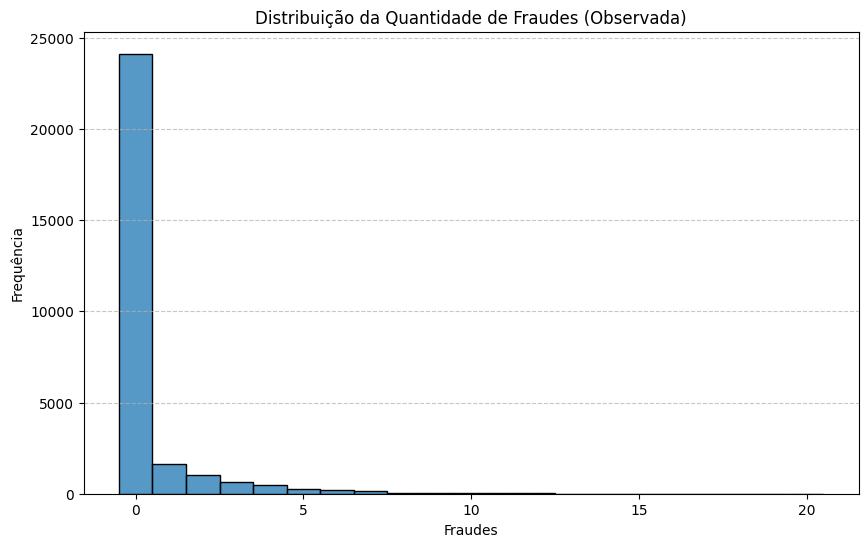

In [135]:
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=range(0, int(np.max(y)) + 2), stat='count', discrete=True)
plt.title('Distribuição da Quantidade de Fraudes (Observada)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, int(np.max(y)) + 1, 5)) # Ajuste os ticks para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Optimization terminated successfully.
         Current function value: 0.736017
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.731063
         Iterations: 41
         Function evaluations: 53
         Gradient evaluations: 53


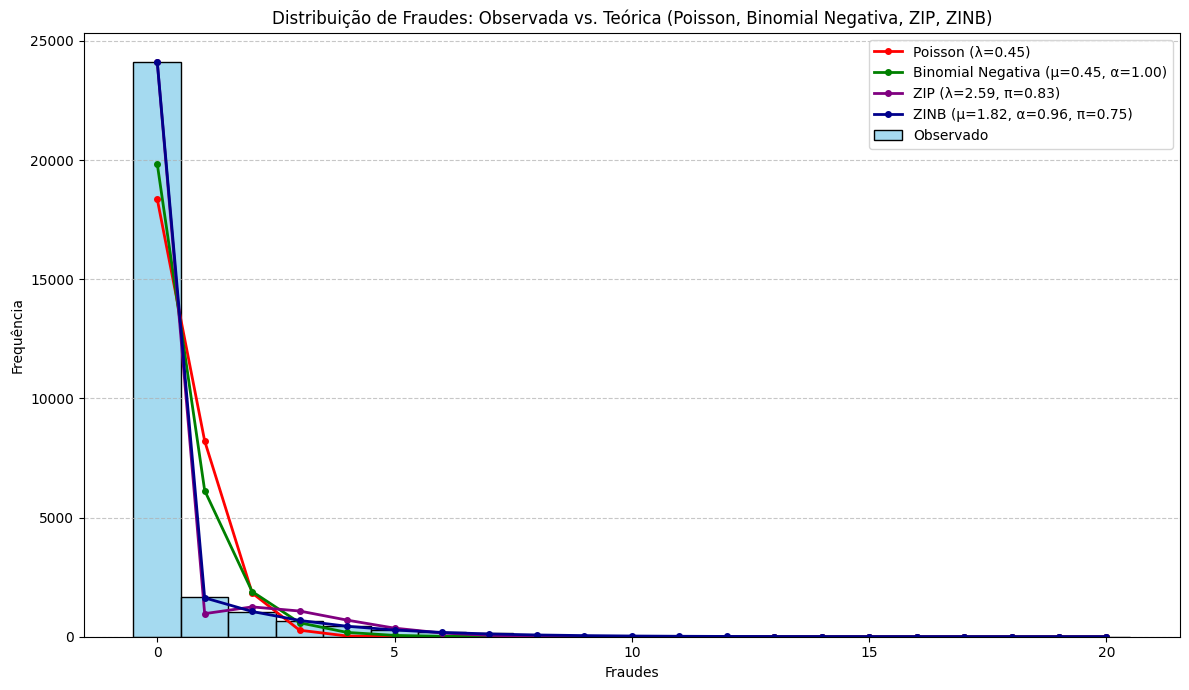

In [136]:
max_fraudes = int(np.max(y))
bins = np.arange(0, max_fraudes + 2)
df_fraudes = pd.DataFrame({'Fraudes': y})

plt.figure(figsize=(12, 7))
ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', label='Observado')

# --- Poisson ---
lambda_poisson = np.mean(y)
poisson_pmf = poisson.pmf(bins[:-1], lambda_poisson)
poisson_freq = poisson_pmf * len(y)
ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

# --- Binomial Negativa ---
exog = np.ones(len(y))
try:
    negbin_model = sm.NegativeBinomial.from_formula("Fraudes ~ 1", data=df_fraudes).fit(disp=True, maxiter=1000)
    mu_negbin = np.exp(negbin_model.params['Intercept'])
    alpha_negbin = negbin_model.scale

    n_param_scipy = 1 / alpha_negbin
    p_param_scipy = n_param_scipy / (n_param_scipy + mu_negbin)
    negbin_pmf = nbinom.pmf(bins[:-1], n=n_param_scipy, p=p_param_scipy)
    negbin_freq = negbin_pmf * len(y)
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo Binomial Negativa com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Poisson ---
try:
    zip_model = sm.ZeroInflatedPoisson.from_formula("Fraudes ~ 1", data=df_fraudes).fit(maxiter=1000, disp=False)
    lambda_zip = np.exp(zip_model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-zip_model.params['inflate_const'])) # Transformando o logit de volta para probabilidade

    zip_freq = np.zeros_like(bins[:-1], dtype=float)
    for k in bins[:-1]:
        if k == 0:
            # Probabilidade de ser 0 = (prob de ser zero extra) + (prob de ser 0 pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)) * len(df_fraudes)
        else:
            # Probabilidade de ser k > 0 = (prob de ser k pelo processo Poisson normal * (1 - prob de ser zero extra))
            zip_freq[k] = (1 - pi_zip) * poisson.pmf(k, lambda_zip) * len(df_fraudes)
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZIP com statsmodels: {e}")
    print("Isso pode acontecer com dados muito esparsos ou se o modelo não convergir.")

# --- Zero Inflated Binomial Negative ---
try:
    zinb_model = sm.ZeroInflatedNegativeBinomialP.from_formula(
        "Fraudes ~ 1",
        inflation_formula="~ 1",
        data=df_fraudes
    ).fit(maxiter=1000, cov_type='HC0')

    # Parâmetros da parte Negative Binomial
    mu_zinb = np.exp(zinb_model.params['Intercept']) # Média estimada (exp de intercepto)
    alpha_zinb = zinb_model.params['alpha'] # Parâmetro de dispersão (alpha)

    # Parâmetro da parte de inflação de zeros (probabilidade de ser um zero extra)
    pi_zinb_logit = zinb_model.params['inflate_const'] # Nome do parâmetro pode variar dependendo da versão
    pi_zinb = 1 / (1 + np.exp(-pi_zinb_logit)) # Transformando logit para probabilidade

    # Calcular as frequências teóricas para o ZINB
    zinb_freq = np.zeros_like(bins[:-1], dtype=float)

    n_param_scipy_zinb = 1 / alpha_zinb
    p_param_scipy_zinb = n_param_scipy_zinb / (n_param_scipy_zinb + mu_zinb)

    for k in bins[:-1]:
        if k == 0:
            zinb_freq[k] = (pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n_param_scipy_zinb, p=p_param_scipy_zinb)) * len(df_fraudes)
        else:
            zinb_freq[k] = (1 - pi_zinb) * nbinom.pmf(k, n=n_param_scipy_zinb, p=p_param_scipy_zinb) * len(df_fraudes)
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)
except Exception as e:
    print(f"Não foi possível ajustar o modelo ZINB: {e}")
    print("Verifique se a versão do statsmodels é recente o suficiente ou se os dados são muito extremos.")


plt.title('Distribuição de Fraudes: Observada vs. Teórica (Poisson, Binomial Negativa, ZIP, ZINB)')
plt.xlabel('Fraudes')
plt.ylabel('Frequência')
plt.xticks(range(0, max_fraudes + 1, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### Métodos Auxiliares

In [137]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [138]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

In [139]:
def overdisp_plot(model, model_type_name):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues.apply(lambda x: 0 if np.isnan(x) or int(round(x))< 0 else int(round(x)))

  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Taxa de Fraudes)")
  plt.ylabel("Resíduos de Pearson Padronizados")
  plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

In [140]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

In [141]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp
from typing import Dict, List, Tuple, Optional, Union
from tqdm.auto import tqdm
import gc
import psutil
import weakref
from collections import OrderedDict
import sys
import os
from contextlib import contextmanager

@contextmanager
def suppress_statsmodels_warnings(suppress_level='all'):
    """
    Context manager robusto para suprimir warnings do statsmodels e numpy.

    Parameters
    ----------
    suppress_level : {'all', 'numerical', 'convergence', 'none'}, default='all'
        Nível de supressão de warnings:
        - 'all': Suprime todos os warnings
        - 'numerical': Suprime apenas warnings numéricos (RuntimeWarning, etc.)
        - 'convergence': Suprime warnings de convergência
        - 'none': Não suprime nenhum warning
    """
    if suppress_level == 'none':
        yield
        return

    # Configurar filtros baseado no nível
    with warnings.catch_warnings():
        if suppress_level == 'all':
            warnings.simplefilter("ignore")
        elif suppress_level == 'numerical':
            # Suprimir warnings numéricos específicos
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            warnings.filterwarnings("ignore", message=".*divide by zero.*")
            warnings.filterwarnings("ignore", message=".*invalid value encountered.*")
            warnings.filterwarnings("ignore", message=".*overflow encountered.*")
            warnings.filterwarnings("ignore", message=".*underflow encountered.*")
            # Warnings específicos do statsmodels
            warnings.filterwarnings("ignore", message=".*Maximum Likelihood optimization failed.*")
            warnings.filterwarnings("ignore", message=".*Optimization terminated successfully.*")
        elif suppress_level == 'convergence':
            warnings.filterwarnings("ignore", message=".*Maximum Likelihood optimization failed.*")
            warnings.filterwarnings("ignore", message=".*Optimization terminated successfully.*")
            warnings.filterwarnings("ignore", message=".*iteration limit reached.*")

        # Configurar numpy para não exibir warnings numéricos se necessário
        old_np_err = np.geterr()
        if suppress_level in ['all', 'numerical']:
            np.seterr(divide='ignore', invalid='ignore', over='ignore', under='ignore')

        try:
            yield
        finally:
            # Restaurar configurações do numpy
            if suppress_level in ['all', 'numerical']:
                np.seterr(**old_np_err)

class MemoryEfficientLRUCache:
    """
    Cache LRU otimizado para gerenciamento de memória.

    Implementa cache com limite de tamanho, limpeza automática
    e monitoramento de memória para evitar sobrecarga.
    """

    def __init__(self, max_size=100, memory_limit_mb=500, enable_weak_refs=True):
        self.max_size = max_size
        self.memory_limit_mb = memory_limit_mb
        self.enable_weak_refs = enable_weak_refs
        self._cache = OrderedDict()
        self._weak_cache = weakref.WeakValueDictionary() if enable_weak_refs else None
        self._hits = 0
        self._misses = 0
        self._memory_cleanups = 0

    def get(self, key):
        """Recupera item do cache com LRU."""
        # Tentar cache principal primeiro
        if key in self._cache:
            self._cache.move_to_end(key)
            self._hits += 1
            return self._cache[key]

        # Tentar weak cache se habilitado
        if self._weak_cache and key in self._weak_cache:
            value = self._weak_cache[key]
            if value is not None:
                # Promover de volta ao cache principal se houver espaço
                if len(self._cache) < self.max_size:
                    self._cache[key] = value
                    self._cache.move_to_end(key)
                self._hits += 1
                return value

        self._misses += 1
        return None

    def put(self, key, value):
        """Adiciona item ao cache com verificação de memória."""
        # Verificar limite de memória antes de adicionar
        if self._should_cleanup_memory():
            self._cleanup_memory()

        # Adicionar ao cache principal
        if key in self._cache:
            self._cache.move_to_end(key)
        else:
            if len(self._cache) >= self.max_size:
                # Remove o item mais antigo
                oldest_key, oldest_value = self._cache.popitem(last=False)
                # Move para weak cache se possível
                if self._weak_cache:
                    try:
                        self._weak_cache[oldest_key] = oldest_value
                    except:
                        pass  # Falha silenciosa se objeto não suporta weak ref

        self._cache[key] = value
        self._cache.move_to_end(key)

    def _should_cleanup_memory(self):
        """Verifica se deve limpar memória baseado no uso."""
        try:
            process = psutil.Process()
            memory_mb = process.memory_info().rss / (1024 * 1024)
            return memory_mb > self.memory_limit_mb
        except:
            # Fallback: limpar a cada N itens
            return len(self._cache) > self.max_size * 1.5

    def _cleanup_memory(self):
        """Limpeza agressiva de memória."""
        self._memory_cleanups += 1

        # Reduzir cache principal para 50% do tamanho
        target_size = max(1, self.max_size // 2)
        while len(self._cache) > target_size:
            key, value = self._cache.popitem(last=False)
            # Tentar salvar em weak cache
            if self._weak_cache:
                try:
                    self._weak_cache[key] = value
                except:
                    pass

        # Forçar garbage collection
        gc.collect()

    def clear(self):
        """Limpa completamente o cache."""
        self._cache.clear()
        if self._weak_cache:
            self._weak_cache.clear()
        gc.collect()

    def stats(self):
        """Retorna estatísticas do cache."""
        total_requests = self._hits + self._misses
        hit_rate = (self._hits / total_requests * 100) if total_requests > 0 else 0

        return {
            'hits': self._hits,
            'misses': self._misses,
            'hit_rate_percent': hit_rate,
            'cache_size': len(self._cache),
            'weak_cache_size': len(self._weak_cache) if self._weak_cache else 0,
            'memory_cleanups': self._memory_cleanups,
            'max_size': self.max_size
        }

class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Seletor de features stepwise otimizado para modelos Zero-Inflated (ZIP/ZINB).

    Esta classe implementa um algoritmo de seleção stepwise forward/backward
    para modelos de contagem com inflação de zeros. A versão otimizada inclui
    cache, paralelização, batch processing e progress bars para melhor performance.

    Funcionalidades principais:
    - Seleção automática de features para componentes exógenos e inflacionados
    - Suporte para critérios AIC, BIC e Log-Likelihood
    - Validação de significância estatística
    - Cache inteligente para evitar recomputações
    - Processamento paralelo de features
    - Progress bars elegantes com tqdm
    - Batch processing para eficiência
    - Validação adaptativa baseada na complexidade do modelo
    - **NOVO**: Supressão robusta de warnings numéricos do statsmodels

    Otimizações implementadas:
    1. **Cache de matrizes**: Evita recriação de matrizes de design idênticas
    2. **Cache de modelos**: Reutiliza resultados de modelos já ajustados
    3. **Validação adaptativa**: Pula validações desnecessárias em modelos simples
    4. **Early stopping**: Para validações assim que encontra problema
    5. **Paralelização**: Testa múltiplas features simultaneamente
    6. **Batch processing**: Processa features em lotes para otimização
    7. **Progress bars**: Feedback visual elegante durante o processo
    8. **Otimização de memória**: Gerenciamento eficiente de cache
    9. **Supressão de warnings**: Context manager robusto para warnings numéricos

    Compatível com scikit-learn pipeline através de BaseEstimator e TransformerMixin.

    Examples
    --------
    Exemplo básico com dados de contagem (warnings silenciados):

    >>> import numpy as np
    >>> import pandas as pd
    >>> from stepwise_optimized import StepwiseZeroInflated
    >>>
    >>> # Dados de exemplo
    >>> X = pd.DataFrame({
    ...     'idade': np.random.normal(35, 10, 1000),
    ...     'renda': np.random.exponential(50000, 1000),
    ...     'educacao': np.random.choice([1, 2, 3, 4], 1000),
    ...     'sexo': np.random.choice([0, 1], 1000)
    ... })
    >>> y = np.random.poisson(2, 1000)  # Variável de contagem
    >>> # Adicionar inflação de zeros
    >>> zero_mask = np.random.binomial(1, 0.3, 1000)
    >>> y = np.where(zero_mask, 0, y)
    >>>
    >>> # Configuração com supressão de warnings
    >>> stepwise = StepwiseZeroInflated(
    ...     alpha=0.05,
    ...     model_type='ZINB',          # Pode gerar warnings numéricos
    ...     verbose=False,
    ...     suppress_warnings='all'      # NOVO: Suprime todos os warnings
    ... )
    >>>
    >>> # Ajustar modelo sem warnings
    >>> stepwise.fit(X, y)
    >>>
    >>> # Verificar features selecionadas
    >>> print("Exógenas:", stepwise.columns_exog_)
    >>> print("Inflacionadas:", stepwise.columns_inf_)

    Exemplo com controle fino de warnings:

    >>> # Suprimir apenas warnings numéricos
    >>> stepwise_numerical = StepwiseZeroInflated(
    ...     model_type='ZINB',
    ...     suppress_warnings='numerical'  # Apenas RuntimeWarnings
    ... )
    >>>
    >>> # Suprimir apenas warnings de convergência
    >>> stepwise_convergence = StepwiseZeroInflated(
    ...     model_type='ZINB',
    ...     suppress_warnings='convergence'  # Apenas otimização
    ... )
    >>>
    >>> # Mostrar todos os warnings (útil para debug)
    >>> stepwise_debug = StepwiseZeroInflated(
    ...     model_type='ZINB',
    ...     suppress_warnings='none'  # Nenhum warning suprimido
    ... )

    Notes
    -----
    - Para datasets pequenos (< 1000 amostras): use suppress_warnings='numerical'
    - Para datasets grandes (> 5000 amostras): use suppress_warnings='all'
    - Para debugging: use suppress_warnings='none' e verbose=True
    - Warnings do ZINB são comuns e geralmente não afetam resultados
    - Use suppress_warnings='convergence' se apenas problemas de otimização

    See Also
    --------
    statsmodels.discrete.count_model.ZeroInflatedPoisson : Modelo ZIP base
    statsmodels.discrete.count_model.ZeroInflatedNegativeBinomialP : Modelo ZINB base
    sklearn.feature_selection : Outros métodos de seleção de features
    """

    def __init__(self, alpha=0.05, model_type='ZIP', selection_criterion='AIC', max_iter=100,
                 tolerance=1e-8, verbose=False, model_params=None, fit_params=None,
                 validation_steps=True, use_cache=True, parallel_features=False,
                 n_jobs=None, batch_size=5, early_stopping=True, multicollinearity_threshold=0.95,
                 cache_size=100, memory_limit_mb=1000, enable_memory_monitoring=True,
                 auto_cleanup_frequency=10, force_gc_frequency=50, suppress_warnings='all'):
        """
        Inicializa o seletor stepwise para modelos Zero-Inflated.

        Parameters
        ----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos. Features com p-valor
            maior que alpha são consideradas não significativas e removidas.

            - Valores menores (ex: 0.01) = mais rigoroso, menos features selecionadas
            - Valores maiores (ex: 0.10) = menos rigoroso, mais features selecionadas

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated a ser usado:

            - 'ZIP': Zero-Inflated Poisson (mais simples, assume equidispersão)
            - 'ZINB': Zero-Inflated Negative Binomial (trata sobredispersão)

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos:

            - 'AIC': Akaike Information Criterion (balanceado)
            - 'BIC': Bayesian Information Criterion (penaliza mais a complexidade)
            - 'LLF': Negative Log-Likelihood (pode levar a overfitting)

        max_iter : int, default=100
            Número máximo de iterações do algoritmo stepwise. Cada iteração
            tenta adicionar a melhor feature disponível.

        tolerance : float, default=1e-8
            Tolerância para convergência. O algoritmo para quando a melhoria
            no critério for menor que este valor.

        verbose : bool, default=False
            Controla o tipo de feedback durante o ajuste:

            - False: Mostra progress bars elegantes com tqdm
            - True: Mostra logs detalhados de cada passo

        model_params : dict, optional
            Parâmetros adicionais passados para o modelo statsmodels.

            Exemplos:
            - {'offset': offset_array} para incluir offset
            - {'exposure': exposure_array} para dados de exposição

        fit_params : dict, optional
            Parâmetros adicionais passados para o método fit() do modelo.

            Exemplos:
            - {'maxiter': 1000} para mais iterações de otimização
            - {'method': 'bfgs'} para método de otimização específico

        validation_steps : bool, default=True
            Se deve realizar validações adicionais dos modelos:

            - True: Valida convergência, multicolinearidade, etc.
            - False: Apenas validação de significância (mais rápido)

        use_cache : bool, default=True
            Se deve usar cache para otimização de performance:

            - True: Cacheia matrizes e modelos (recomendado)
            - False: Recalcula tudo (útil para debugging)

        parallel_features : bool, default=False
            Se deve testar features em paralelo:

            - True: Usa múltiplas threads (melhor para datasets grandes)
            - False: Processamento sequencial (melhor para datasets pequenos)

        n_jobs : int, optional
            Número de threads para processamento paralelo.
            Se None, usa min(4, número_de_cores).

            - 1: Sem paralelismo
            - 2-4: Bom para a maioria dos casos
            - -1: Usa todos os cores disponíveis

        batch_size : int, default=5
            Número de features processadas em cada lote:

            - Valores menores (3-5): Melhor para datasets pequenos
            - Valores maiores (8-12): Melhor para datasets grandes

        early_stopping : bool, default=True
            Se deve usar early stopping para otimizar performance:

            - True: Para validações assim que encontra problemas (mais rápido)
            - False: Executa todas as validações completas (mais confiável)

        multicollinearity_threshold : float, default=0.95
            Limiar de correlação absoluta para detectar multicolinearidade.
            Features com correlação acima deste valor são rejeitadas.

            - Valores menores (ex: 0.80) = mais rigoroso, rejeita mais features
            - Valores maiores (ex: 0.99) = menos rigoroso, aceita correlações altas
            - 0.95: Padrão conservador para a maioria dos casos
            - 0.90: Rigoroso para modelos de produção
            - 0.80: Muito rigoroso para dados com features similares

        cache_size : int, default=100
            Tamanho máximo do cache LRU para modelos e matrizes.

            - Valores menores (50-100): Para datasets pequenos ou memória limitada
            - Valores maiores (200-500): Para datasets grandes com muita reutilização
            - 100: Padrão balanceado para a maioria dos casos

        memory_limit_mb : int, default=1000
            Limite de memória RAM em MB antes de forçar limpeza automática.

            - Valores menores (500-1000): Para sistemas com pouca memória
            - Valores maiores (2000-4000): Para workstations com muita RAM
            - 1000: Padrão conservador (1GB)

        enable_memory_monitoring : bool, default=True
            Se deve monitorar uso de memória e fazer limpezas automáticas.

            - True: Monitoramento ativo com limpeza automática (recomendado)
            - False: Sem monitoramento (útil para debugging)

        auto_cleanup_frequency : int, default=10
            Frequência de limpeza automática a cada N iterações.

            - Valores menores (5-10): Limpeza mais frequente, menos memória
            - Valores maiores (20-50): Limpeza menos frequente, mais performance

        force_gc_frequency : int, default=50
            Frequência de garbage collection forçado a cada N iterações.

            - Valores menores (20-50): GC mais frequente
            - Valores maiores (100-200): GC menos frequente

        suppress_warnings : {'all', 'numerical', 'convergence', 'none'}, default='all'
            **NOVO PARÂMETRO**: Controla supressão de warnings do statsmodels/numpy:

            - 'all': Suprime todos os warnings (recomendado para produção)
            - 'numerical': Suprime apenas RuntimeWarnings numéricos (divide by zero, etc.)
            - 'convergence': Suprime apenas warnings de otimização/convergência
            - 'none': Não suprime warnings (útil para debugging)

            **Quando usar cada opção:**
            - 'all': Produção, apresentações, quando warnings não são relevantes
            - 'numerical': Quando quer ver problemas de convergência mas não numéricos
            - 'convergence': Quando quer ver problemas numéricos mas não de otimização
            - 'none': Debugging, desenvolvimento, investigação de problemas

        Examples
        --------
        Configuração para sistemas com pouca memória (sem warnings):

        >>> stepwise_low_memory = StepwiseZeroInflated(
        ...     cache_size=50,                    # Cache pequeno
        ...     memory_limit_mb=500,              # Limite baixo de RAM
        ...     auto_cleanup_frequency=5,         # Limpeza frequente
        ...     enable_memory_monitoring=True,    # Monitoramento ativo
        ...     suppress_warnings='all'           # Sem warnings
        ... )

        Configuração para debugging (com todos os warnings):

        >>> stepwise_debug = StepwiseZeroInflated(
        ...     verbose=True,                     # Logs detalhados
        ...     suppress_warnings='none',         # Todos os warnings visíveis
        ...     use_cache=False,                  # Sem cache para debug
        ...     validation_steps=True             # Validação completa
        ... )

        Configuração para ZINB (warnings numéricos silenciados):

        >>> stepwise_zinb = StepwiseZeroInflated(
        ...     model_type='ZINB',               # Pode gerar warnings numéricos
        ...     suppress_warnings='numerical',   # Apenas warnings numéricos
        ...     verbose=False                    # Progress bars
        ... )

        Raises
        ------
        ValueError
            Se alpha não estiver entre 0 e 1, model_type não for 'ZIP' ou 'ZINB',
            selection_criterion não for válido, max_iter <= 0, tolerance <= 0,
            multicollinearity_threshold não estiver entre 0 e 1, cache_size <= 0,
            memory_limit_mb <= 0, frequências de limpeza <= 0, ou suppress_warnings
            não for uma opção válida.

        Notes
        -----
        - Para datasets pequenos (<1K amostras): cache_size=50, memory_limit_mb=500
        - Para datasets médios (1K-10K amostras): configuração padrão
        - Para datasets grandes (>10K amostras): cache_size=200+, memory_limit_mb=2000+
        - O monitoramento de memória usa psutil se disponível, senão usa heurísticas
        - **Warnings ZINB**: RuntimeWarnings são comuns e geralmente seguros de ignorar
        - **Debugging**: Use suppress_warnings='none' + verbose=True para investigar problemas
        - **Produção**: Use suppress_warnings='all' para logs limpos
        """

        # Parâmetros originais
        if not 0 < alpha < 1:
            raise ValueError("alpha deve estar entre 0 e 1")
        if model_type not in ['ZIP', 'ZINB']:
            raise ValueError("model_type deve ser 'ZIP' ou 'ZINB'")
        if selection_criterion not in ['AIC', 'BIC', 'LLF']:
            raise ValueError("selection_criterion deve ser 'AIC', 'BIC' ou 'LLF'")
        if max_iter <= 0:
            raise ValueError("max_iter deve ser positivo")
        if tolerance <= 0:
            raise ValueError("tolerance deve ser positivo")
        if not 0 < multicollinearity_threshold < 1:
            raise ValueError("multicollinearity_threshold deve estar entre 0 e 1")

        # Validações dos novos parâmetros de memória
        if cache_size <= 0:
            raise ValueError("cache_size deve ser positivo")
        if memory_limit_mb <= 0:
            raise ValueError("memory_limit_mb deve ser positivo")
        if auto_cleanup_frequency <= 0:
            raise ValueError("auto_cleanup_frequency deve ser positivo")
        if force_gc_frequency <= 0:
            raise ValueError("force_gc_frequency deve ser positivo")

        # NOVA VALIDAÇÃO: suppress_warnings
        if suppress_warnings not in ['all', 'numerical', 'convergence', 'none']:
            raise ValueError("suppress_warnings deve ser 'all', 'numerical', 'convergence' ou 'none'")

        self.alpha = alpha
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.verbose = verbose
        self.model_params = model_params if model_params is not None else {}
        self.fit_params = fit_params if fit_params is not None else {}
        self.validation_steps = validation_steps
        self.multicollinearity_threshold = multicollinearity_threshold

        # Parâmetros de otimização existentes
        self.use_cache = use_cache
        self.parallel_features = parallel_features
        # Corrigir tratamento de n_jobs = -1
        if n_jobs == -1:
            self.n_jobs = mp.cpu_count()
        elif n_jobs is None:
            self.n_jobs = min(4, mp.cpu_count())
        elif n_jobs > 0:
            self.n_jobs = n_jobs
        else:
            raise ValueError("n_jobs deve ser positivo ou -1 para usar todos os cores")
        self.batch_size = max(1, batch_size)
        self.early_stopping = early_stopping

        # Novos parâmetros de gerenciamento de memória
        self.cache_size = cache_size
        self.memory_limit_mb = memory_limit_mb
        self.enable_memory_monitoring = enable_memory_monitoring
        self.auto_cleanup_frequency = auto_cleanup_frequency
        self.force_gc_frequency = force_gc_frequency

        # NOVO PARÂMETRO: controle de warnings
        self.suppress_warnings = suppress_warnings

        # Cache otimizado para gerenciamento de memória
        self._matrix_cache = MemoryEfficientLRUCache(
            max_size=cache_size // 2,  # 50% para matrizes
            memory_limit_mb=memory_limit_mb,
            enable_weak_refs=True
        )
        self._model_cache = MemoryEfficientLRUCache(
            max_size=cache_size,  # 100% para modelos (mais importantes)
            memory_limit_mb=memory_limit_mb,
            enable_weak_refs=True
        )

        # Contadores de limpeza e monitoramento
        self._iteration_count = 0
        self._last_cleanup_iteration = 0
        self._last_gc_iteration = 0
        self._total_memory_cleanups = 0

        self._setup_criterion_behavior()

    def _setup_criterion_behavior(self):
        """
        Configura comportamento específico para cada critério de seleção.

        Emite warnings para critérios que podem levar a problemas,
        especialmente o LLF que pode causar overfitting em seleção stepwise.
        """
        if self.selection_criterion == 'LLF':
            warnings.warn(
                "LLF como critério de seleção pode levar a overfitting. "
                "Considere usar 'AIC' ou 'BIC' para seleção stepwise.",
                UserWarning
            )

    def _get_model_criterion(self, result):
        """
        Extrai o valor do critério de seleção do modelo ajustado.

        Parameters
        ----------
        result : statsmodels fitted model
            Resultado do ajuste do modelo.

        Returns
        -------
        criterion : float
            Valor do critério de seleção configurado.

        Notes
        -----
        - AIC e BIC: valores menores são melhores
        - LLF: usa o negativo da log-likelihood para consistência
        """
        if self.selection_criterion == 'AIC':
            return result.aic
        elif self.selection_criterion == 'BIC':
            return result.bic
        elif self.selection_criterion == 'LLF':
            return -result.llf

    def _get_criterion_name(self):
        """
        Retorna nome amigável do critério para exibição em logs.

        Returns
        -------
        name : str
            Nome legível do critério de seleção.
        """
        criterion_names = {
            'AIC': 'AIC',
            'BIC': 'BIC',
            'LLF': '-Log-Likelihood'
        }
        return criterion_names[self.selection_criterion]

    def _get_matrix_cache_key(self, exog_features: List[str], inf_features: List[str]) -> str:
        """Gera chave única para cache de matrizes."""
        exog_str = ','.join(sorted(exog_features))
        inf_str = ','.join(sorted(inf_features))
        return f"exog:[{exog_str}]_inf:[{inf_str}]"

    def _prepare_matrices_cached(self, X: pd.DataFrame, exog_features: List[str],
                                inf_features: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Prepara matrizes com cache para evitar recriação desnecessária."""
        cache_key = self._get_matrix_cache_key(exog_features, inf_features)

        if self.use_cache:
            cached_result = self._matrix_cache.get(cache_key)
            if cached_result is not None:
                return cached_result

        # Preparar matriz exógena
        if exog_features:
            X1 = X[exog_features].copy()
            X1 = sm.add_constant(X1, has_constant='add')
        else:
            X1 = pd.DataFrame({'const': np.ones(len(X))})

        # Preparar matriz inflacionada
        if inf_features:
            X2 = X[inf_features].copy()
            X2 = sm.add_constant(X2, has_constant='add')
        else:
            X2 = pd.DataFrame({'const': np.ones(len(X))})

        # Armazenar no cache
        result = (X1, X2)
        if self.use_cache:
            self._matrix_cache.put(cache_key, result)

        return result

    def _get_model_cache_key(self, exog_features: List[str], inf_features: List[str],
                           data_hash: str) -> str:
        """Gera chave única para cache de modelos."""
        matrix_key = self._get_matrix_cache_key(exog_features, inf_features)
        return f"{matrix_key}_data:{data_hash}_type:{self.model_type}"

    def _fit_model_cached(self, X: pd.DataFrame, y: np.ndarray, exog_features: List[str],
                         inf_features: List[str]) -> Optional[object]:
        """Ajusta modelo com cache para evitar recomputação."""

        # Gerar hash simples dos dados para cache
        data_hash = str(hash((tuple(y), tuple(X.columns))))[:8]
        cache_key = self._get_model_cache_key(exog_features, inf_features, data_hash)

        if self.use_cache:
            cached_result = self._model_cache.get(cache_key)
            if cached_result is not None:
                return cached_result

        try:
            # Preparar matrizes
            X1, X2 = self._prepare_matrices_cached(X, exog_features, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            # Ajustar modelo com supressão de warnings robusta
            model = ModelClass(y, X1, exog_infl=X2, **self.model_params)

            with suppress_statsmodels_warnings(self.suppress_warnings):
                result = model.fit(**self.fit_params)

            # Armazenar no cache
            if self.use_cache:
                self._model_cache.put(cache_key, result)

            return result

        except Exception:
            return None

    def _validate_features_significance_fast(self, result, exog_features: List[str],
                                           inf_features: List[str]) -> Tuple[bool, str]:
        """Validação rápida de significância com early stopping opcional."""
        try:
            # Verificar se temos parâmetros suficientes
            expected_params = 1 + len(exog_features) + 1 + len(inf_features)
            if len(result.pvalues) < expected_params:
                return False, "parâmetros insuficientes"

            # Coletar todas as features não-significativas se early_stopping=False
            non_significant_features = []

            # Verificar features exógenas
            for i, feature in enumerate(exog_features):
                try:
                    p_value = result.pvalues.iloc[i + 1]
                    if pd.isna(p_value) or p_value >= self.alpha:
                        if self.early_stopping:
                            # Early stopping: retornar imediatamente
                            return False, f"{feature} não significativa (p={p_value:.4f})"
                        else:
                            # Sem early stopping: coletar todos os problemas
                            non_significant_features.append(f"{feature} (p={p_value:.4f})")
                except (IndexError, KeyError):
                    error_msg = f"{feature} erro no p-valor"
                    if self.early_stopping:
                        return False, error_msg
                    else:
                        non_significant_features.append(error_msg)

            # Verificar features inflacionadas
            n_exog = len(exog_features) + 1
            for i, feature in enumerate(inf_features):
                try:
                    p_value = result.pvalues.iloc[n_exog + i + 1]
                    if pd.isna(p_value) or p_value >= self.alpha:
                        if self.early_stopping:
                            # Early stopping: retornar imediatamente
                            return False, f"{feature} não significativa (p={p_value:.4f})"
                        else:
                            # Sem early stopping: coletar todos os problemas
                            non_significant_features.append(f"{feature} (p={p_value:.4f})")
                except (IndexError, KeyError):
                    error_msg = f"{feature} erro no p-valor"
                    if self.early_stopping:
                        return False, error_msg
                    else:
                        non_significant_features.append(error_msg)

            # Se encontrou features não-significativas e não está usando early stopping
            if non_significant_features and not self.early_stopping:
                return False, f"Features não significativas: {'; '.join(non_significant_features)}"

            return True, "todas significativas"

        except Exception as e:
            return False, f"erro validação: {str(e)[:30]}"

    def _test_feature_scenarios_batch(self, X: pd.DataFrame, y: np.ndarray,
                                    candidate_features: List[str], current_exog: List[str],
                                    current_inf: List[str]) -> List[Dict]:
        """Testa múltiplas features em batch para otimização."""
        results = []

        if self.parallel_features and len(candidate_features) > 1:
            # Processamento paralelo
            with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
                future_to_feature = {}

                for feature in candidate_features:
                    future = executor.submit(
                        self._test_single_feature_all_scenarios,
                        X, y, feature, current_exog, current_inf
                    )
                    future_to_feature[future] = feature

                # Processar resultados conforme completam
                for future in as_completed(future_to_feature):
                    feature = future_to_feature[future]
                    try:
                        result = future.result()
                        result['feature'] = feature
                        results.append(result)
                    except Exception as e:
                        if self.verbose:
                            print(f"Erro testando '{feature}': {str(e)[:50]}")
                        results.append({
                            'feature': feature,
                            'best_criterion': None,
                            'best_scenario': None,
                            'reason': f"erro: {str(e)[:30]}"
                        })
        else:
            # Processamento sequencial
            for feature in candidate_features:
                try:
                    result = self._test_single_feature_all_scenarios(X, y, feature, current_exog, current_inf)
                    result['feature'] = feature
                    results.append(result)
                except Exception as e:
                    if self.verbose:
                        print(f"Erro testando '{feature}': {str(e)[:50]}")
                    results.append({
                        'feature': feature,
                        'best_criterion': None,
                        'best_scenario': None,
                        'reason': f"erro: {str(e)[:30]}"
                    })

        return results

    def _test_single_feature_all_scenarios(self, X: pd.DataFrame, y: np.ndarray,
                                         feature: str, current_exog: List[str],
                                         current_inf: List[str]) -> Dict:
        """Testa uma feature em todos os cenários possíveis."""
        best_criterion = float('inf')
        best_scenario = None
        best_config = None

        scenarios_to_test = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambas" se aplicável
        if current_exog or current_inf:
            scenarios_to_test.append(
                ('both', current_exog + [feature], current_inf + [feature])
            )

        for scenario_name, test_exog, test_inf in scenarios_to_test:
            # Ajustar modelo
            result = self._fit_model_cached(X, y, test_exog, test_inf)

            if result is None:
                continue

            # Validação rápida de significância
            is_significant, sig_details = self._validate_features_significance_fast(
                result, test_exog, test_inf
            )

            if not is_significant:
                continue

            # Validação adaptativa (pula etapas se não necessário)
            if self.validation_steps:
                passed_validation, _ = self._validate_model_adaptive(
                    X, y, test_exog, test_inf, result
                )
                if not passed_validation:
                    continue

            # Obter critério
            criterion = self._get_model_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_scenario = scenario_name
                best_config = (test_exog, test_inf)

        return {
            'best_criterion': best_criterion if best_criterion != float('inf') else None,
            'best_scenario': best_scenario,
            'best_config': best_config,
            'reason': 'aprovada' if best_scenario else 'rejeitada'
        }

    def _validate_model_adaptive(self, X: pd.DataFrame, y: np.ndarray,
                               exog_features: List[str], inf_features: List[str],
                               result) -> Tuple[bool, str]:
        """Validação adaptativa que pula etapas desnecessárias quando early_stopping=True."""

        total_features = len(exog_features) + len(inf_features)

        # Se early stopping está desabilitado, sempre fazer validação completa
        if not self.early_stopping:
            return self._validate_full_robustness(X, y, exog_features, inf_features, result)

        # Com early stopping, usar validação adaptativa baseada na complexidade
        # Para modelos simples (1-2 features), pular validações pesadas
        if total_features <= 2:
            return True, "modelo simples"

        # Para modelos médios (3-5 features), validação básica
        if total_features <= 5:
            return self._validate_basic_stability(X, y, exog_features, inf_features, result)

        # Para modelos complexos (6+ features), validação completa
        return self._validate_full_robustness(X, y, exog_features, inf_features, result)

    def _validate_basic_stability(self, X: pd.DataFrame, y: np.ndarray,
                                exog_features: List[str], inf_features: List[str],
                                result) -> Tuple[bool, str]:
        """Validação básica de estabilidade para modelos médios."""
        try:
            # Verificar apenas convergência e multicolinearidade básica
            if hasattr(result, 'mle_retvals') and not result.mle_retvals.get('converged', True):
                return False, "não convergiu"

            # Multicolinearidade básica apenas se muitas features
            if len(exog_features) > 3:
                corr_matrix = X[exog_features].corr().abs()
                max_corr = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max()
                if max_corr > self.multicollinearity_threshold:
                    return False, f"multicolinearidade alta (r={max_corr:.3f} > {self.multicollinearity_threshold:.2f})"

            status_msg = "estabilidade básica aprovada"
            if not self.early_stopping:
                status_msg += " (validação completa)"
            return True, status_msg

        except Exception:
            return False, "erro na validação básica"

    def _validate_full_robustness(self, X: pd.DataFrame, y: np.ndarray,
                                exog_features: List[str], inf_features: List[str],
                                result) -> Tuple[bool, str]:
        """Validação completa para modelos complexos ou quando early_stopping=False."""
        try:
            # Validação básica sempre
            basic_passed, basic_msg = self._validate_basic_stability(X, y, exog_features, inf_features, result)
            if not basic_passed:
                return False, basic_msg

            # Validações adicionais quando early stopping está desabilitado
            if not self.early_stopping:
                validation_issues = []

                # Verificar condição dos valores ajustados
                try:
                    fitted_values = result.fittedvalues
                    if np.any(np.isnan(fitted_values)) or np.any(fitted_values < 0):
                        validation_issues.append("valores ajustados inválidos")
                except Exception:
                    validation_issues.append("erro nos valores ajustados")

                # Verificar matriz de covariância
                try:
                    cov_matrix = result.cov_params()
                    if np.any(np.diag(cov_matrix) <= 0):
                        validation_issues.append("matriz covariância inválida")
                except Exception:
                    validation_issues.append("erro na matriz de covariância")

                # Verificar multicolinearidade rigorosa para todos os conjuntos
                all_features = exog_features + inf_features
                if len(all_features) > 2:
                    try:
                        corr_matrix = X[all_features].corr().abs()
                        max_corr = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].max()
                        if max_corr > self.multicollinearity_threshold:  # Usa limiar parametrizado
                            validation_issues.append(f"multicolinearidade severa (r={max_corr:.3f} > {self.multicollinearity_threshold:.2f})")
                    except Exception:
                        validation_issues.append("erro na verificação de multicolinearidade")

                # Se há problemas e não está usando early stopping, reportar todos
                if validation_issues:
                    return False, f"Problemas encontrados: {'; '.join(validation_issues)}"

                return True, f"validação completa aprovada (limiar multicolinearidade: {self.multicollinearity_threshold:.2f})"

            # Com early stopping, usar apenas validação básica
            return True, f"validação robusta aprovada (limiar multicolinearidade: {self.multicollinearity_threshold:.2f})"

        except Exception as e:
            return False, f"erro na validação completa: {str(e)[:30]}"

    def _stepwise_selection_optimized(self, X: pd.DataFrame, y: np.ndarray) -> Dict:
        """Versão otimizada do algoritmo stepwise."""

        # Inicialização
        columns_exog = []
        columns_inf = []
        excluded = []
        available_features = list(X.columns)

        criterion_history = []
        step_history = []

        # NOVA LÓGICA: rastrear todas as features testadas quando early_stopping=False
        all_features_tested = set()

        # Reset contadores de monitoramento
        self._iteration_count = 0
        self._last_cleanup_iteration = 0
        self._last_gc_iteration = 0

        # Otimizar DataFrame de entrada se necessário
        if self.enable_memory_monitoring:
            initial_memory = self._get_memory_usage_mb()
            if self.verbose:
                print(f"Memória inicial: {initial_memory:.1f}MB")
            X = self._optimize_dataframe_memory(X)

        # Modelo baseline
        initial_criterion = self._calculate_baseline_criterion_fast(y)
        best_criterion = initial_criterion
        criterion_history.append(initial_criterion)

        if self.verbose:
            print(f"STEPWISE OTIMIZADO INICIADO")
            print(f"Cache habilitado: {self.use_cache}")
            print(f"Processamento paralelo: {self.parallel_features}")
            print(f"Critério inicial: {initial_criterion:.2f}")
            print(f"Modo validação: {'TODAS as features' if not self.early_stopping else 'early stopping'}")
            print(f"Monitoramento de memória: {self.enable_memory_monitoring}")
            if self.enable_memory_monitoring:
                print(f"Limite de memória: {self.memory_limit_mb}MB")
                print(f"Tamanho do cache: {self.cache_size}")
            print("-" * 60)

        # Configurar barras de progresso quando verbose=False
        use_progress = not self.verbose
        pbar_iterations = None

        if use_progress:
            # Barra única com informações consolidadas
            pbar_iterations = tqdm(
                total=self.max_iter,
                desc="Stepwise Selection",
                unit="iter",
                position=0,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]'
            )

        # Loop principal otimizado
        for iteration in range(self.max_iter):
            improved = False

            # Monitoramento e limpeza de memória
            self._monitor_and_cleanup_memory()

            # Processar features em batches
            remaining_features = [f for f in available_features
                                if f not in columns_exog and f not in columns_inf and f not in excluded]

            # NOVA LÓGICA: quando early_stopping=False, testar features não testadas primeiro
            if not self.early_stopping:
                untested_features = [f for f in remaining_features if f not in all_features_tested]
                if untested_features:
                    # Prioritizar features não testadas
                    remaining_features = untested_features
                elif remaining_features:
                    # Se todas foram testadas mas ainda há features restantes, testar novamente
                    # (pode haver diferentes combinações agora)
                    all_features_tested.clear()  # Reset para nova rodada
                    remaining_features = remaining_features
                else:
                    # Todas as features foram testadas e processadas
                    if self.verbose:
                        print(f"TODAS as {len(available_features)} features foram testadas e processadas")
                    break

            if not remaining_features:
                if use_progress:
                    pbar_iterations.close()
                break

            # Dividir em batches para processamento eficiente
            batches = [remaining_features[i:i+self.batch_size]
                      for i in range(0, len(remaining_features), self.batch_size)]

            best_addition = None
            iteration_excluded = []  # Features excluídas nesta iteração

            for batch_idx, batch in enumerate(batches):
                if self.verbose:
                    print(f"Iteração {iteration+1}: testando batch {batch_idx+1}/{len(batches)} de {len(batch)} features")

                # MARCAR FEATURES COMO TESTADAS (quando early_stopping=False)
                if not self.early_stopping:
                    all_features_tested.update(batch)

                # Testar batch de features
                batch_results = self._test_feature_scenarios_batch(
                    X, y, batch, columns_exog, columns_inf
                )

                # Encontrar melhor resultado do batch E processar exclusões
                for result in batch_results:
                    if (result['best_criterion'] is not None and
                        result['best_criterion'] < best_criterion):

                        if best_addition is None or result['best_criterion'] < best_addition['criterion']:
                            best_addition = {
                                'feature': result['feature'],
                                'criterion': result['best_criterion'],
                                'scenario': result['best_scenario'],
                                'config': result['best_config']
                            }
                    else:
                        # NOVA LÓGICA: quando early_stopping=False, não excluir imediatamente
                        # Só excluir após todas as features serem testadas
                        if self.early_stopping:
                            excluded.append(result['feature'])
                        else:
                            iteration_excluded.append(result['feature'])

            # Aplicar melhor adição se houver
            if best_addition:
                columns_exog, columns_inf = best_addition['config']
                best_criterion = best_addition['criterion']
                improved = True

                if self.verbose:
                    improvement = criterion_history[-1] - best_criterion
                    print(f"Adicionada '{best_addition['feature']}' como {best_addition['scenario']} "
                          f"(melhoria: {improvement:.2f})")

                # Limpar das exclusões da iteração se foi selecionada
                if best_addition['feature'] in iteration_excluded:
                    iteration_excluded.remove(best_addition['feature'])

            # NOVA LÓGICA: só adicionar às exclusões quando necessário
            if self.early_stopping:
                # Modo normal: adicionar exclusões imediatamente
                pass  # já foi feito acima
            else:
                # Modo validação completa: só excluir quando não há mais o que testar
                # e a feature foi rejeitada consistentemente
                if not remaining_features or len(all_features_tested) >= len(available_features):
                    excluded.extend(iteration_excluded)

            # Backward elimination otimizado
            if improved:
                removed_any = self._backward_elimination_optimized(
                    X, y, columns_exog, columns_inf, best_criterion
                )
                if removed_any:
                    best_criterion = removed_any['new_criterion']
                    columns_exog = removed_any['new_exog']
                    columns_inf = removed_any['new_inf']
                    excluded.extend(removed_any['removed_features'])

            criterion_history.append(best_criterion)

            # Atualizar barra de progresso das iterações
            if use_progress and pbar_iterations:
                selected_features = len(columns_exog) + len(columns_inf)
                tested_features = len(all_features_tested) if not self.early_stopping else len(excluded) + selected_features
                remaining_count = len(remaining_features) if 'remaining_features' in locals() else 0

                # Calcular progresso real das features
                total_features = len(available_features)
                feature_progress = f"{tested_features}/{total_features}"

                # Status mais detalhado
                status_details = []
                if improved:
                    improvement = criterion_history[-2] - best_criterion if len(criterion_history) > 1 else 0
                    status_details.append(f"↗ melhorou {improvement:.2f}")
                else:
                    status_details.append("→ sem melhoria")

                if not self.early_stopping:
                    status_details.append(f"({remaining_count} restantes)")

                pbar_iterations.set_postfix({
                    'features': selected_features,
                    'testadas': feature_progress,
                    self.selection_criterion: f"{best_criterion:.2f}",
                    'status': " ".join(status_details)
                })
                pbar_iterations.update(1)

            # NOVA LÓGICA DE CONVERGÊNCIA: diferente para early_stopping=True/False
            if self.early_stopping:
                # Modo normal: parar se não melhorou
                if not improved and len(criterion_history) > 1:
                    criterion_change = abs(criterion_history[-2] - criterion_history[-1])
                    if criterion_change < self.tolerance:
                        if self.verbose:
                            print(f"Convergência atingida (mudança: {criterion_change:.6f})")
                        if use_progress:
                            pbar_iterations.set_description("Convergiu")
                            pbar_iterations.close()
                        break

                if not improved:
                    if self.verbose:
                        print(f"Nenhuma melhoria na iteração {iteration+1}")
                    if use_progress:
                        pbar_iterations.set_description("Sem melhoria")
                        pbar_iterations.close()
                    break
            else:
                # Modo validação completa: continuar até testar TODAS as features
                total_processed = len(columns_exog) + len(columns_inf) + len(excluded)
                if total_processed >= len(available_features):
                    if self.verbose:
                        print(f"TODAS as {len(available_features)} features foram processadas")
                        print(f"Selecionadas: {len(columns_exog) + len(columns_inf)}, "
                              f"Excluídas: {len(excluded)}")
                    if use_progress:
                        pbar_iterations.set_description("Todas testadas")
                        pbar_iterations.close()
                    break

                # Continuar mesmo sem melhoria para testar todas as features
                if not improved and self.verbose:
                    print(f"Sem melhoria na iteração {iteration+1}, mas continuando "
                          f"(testadas: {len(all_features_tested)}/{len(available_features)})")

        # Fechar barras de progresso se ainda estiverem abertas
        if use_progress:
            if pbar_iterations:
                pbar_iterations.close()

        # RELATÓRIO FINAL melhorado
        if self.verbose:
            print(f"\nStepwise finalizado:")
            print(f"Modo: {'VALIDAÇÃO COMPLETA' if not self.early_stopping else 'EARLY STOPPING'}")
            print(f"Features disponíveis: {len(available_features)}")
            print(f"Features testadas: {len(all_features_tested) if not self.early_stopping else 'N/A'}")
            print(f"Features selecionadas: {len(columns_exog) + len(columns_inf)}")
            print(f"  - Exógenas: {columns_exog}")
            print(f"  - Inflacionadas: {columns_inf}")
            print(f"Features excluídas: {len(excluded)}")
            print(f"Cache hits/misses: {self._cache_hits}/{self._cache_misses}")
            if self._cache_hits + self._cache_misses > 0:
                hit_rate = self._cache_hits / (self._cache_hits + self._cache_misses) * 100
                print(f"Taxa de acerto do cache: {hit_rate:.1f}%")

        return {
            'columns_exog': columns_exog,
            'columns_inf': columns_inf,
            'excluded': excluded,
            'criterion_history': criterion_history,
            'step_history': step_history,
            'total_features_tested': len(all_features_tested) if not self.early_stopping else len(excluded) + len(columns_exog) + len(columns_inf),
            'validation_mode': 'complete' if not self.early_stopping else 'early_stopping'
        }

    def _backward_elimination_optimized(self, X: pd.DataFrame, y: np.ndarray,
                                      current_exog: List[str], current_inf: List[str],
                                      current_criterion: float) -> Optional[Dict]:
        """Backward elimination otimizado."""

        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return None

        best_removal = None
        removed_features = []

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            result = self._fit_model_cached(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validação rápida
            is_significant, _ = self._validate_features_significance_fast(result, test_exog, test_inf)
            if not is_significant:
                continue

            criterion = self._get_model_criterion(result)

            # Se remover melhora ou mantém o critério, marcar para remoção
            if criterion <= current_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'criterion': criterion,
                        'new_exog': test_exog,
                        'new_inf': test_inf
                    }

        if best_removal:
            return {
                'new_criterion': best_removal['criterion'],
                'new_exog': best_removal['new_exog'],
                'new_inf': best_removal['new_inf'],
                'removed_features': [best_removal['feature']]
            }

        return None

    def _calculate_baseline_criterion_fast(self, y: np.ndarray) -> float:
        """Cálculo rápido do critério baseline."""
        try:
            # Usar cache se possível
            baseline_key = f"baseline_{self.model_type}_{len(y)}_{hash(tuple(y))}"

            if self.use_cache and baseline_key in self._model_cache:
                result = self._model_cache[baseline_key]
                return self._get_model_criterion(result)

            # Calcular baseline
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            elif self.model_type == 'ZINB':
                ModelClass = sm.ZeroInflatedNegativeBinomialP
            else:
                raise ValueError(f"model_type '{self.model_type}' não suportado")

            model = ModelClass(y, X_const, exog_infl=X_const, **self.model_params)

            with suppress_statsmodels_warnings(self.suppress_warnings):
                result = model.fit(**self.fit_params)

            if self.use_cache:
                self._model_cache[baseline_key] = result

            return self._get_model_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados fornecidos.

        Este método executa o algoritmo de seleção stepwise forward/backward
        para encontrar o melhor subconjunto de features para os componentes
        exógeno e inflacionado do modelo Zero-Inflated.

        O processo inclui:
        1. Limpeza de caches anteriores
        2. Validação e preparação dos dados
        3. Execução do algoritmo stepwise otimizado
        4. Ajuste do modelo final com features selecionadas
        5. Armazenamento dos resultados

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Matriz de features. Pode ser numpy array, pandas DataFrame,
            ou qualquer array-like aceito pelo scikit-learn.

        y : array-like of shape (n_samples,)
            Variável target (contagem). Deve conter apenas valores
            não-negativos inteiros. Zeros são tratados pelo componente
            inflacionado do modelo.

        Returns
        -------
        self : StepwiseZeroInflated
            Instância ajustada do estimador.

        Attributes
        ----------
        Após o ajuste, os seguintes atributos ficam disponíveis:

        columns_exog_ : list
            Nomes das features selecionadas para o componente exógeno
            (que modela a contagem esperada).

        columns_inf_ : list
            Nomes das features selecionadas para o componente inflacionado
            (que modela a probabilidade de zero estrutural).

        excluded_ : list
            Nomes das features que foram testadas mas rejeitadas.

        final_model_ : statsmodels fitted model
            Modelo final ajustado com as features selecionadas.

        criterion_history_ : list
            Histórico dos valores do critério de seleção a cada iteração.

        n_features_in_ : int
            Número de features na entrada.

        feature_names_in_ : ndarray
            Nomes das features na entrada.

        Examples
        --------
        Exemplo básico:

        >>> import pandas as pd
        >>> import numpy as np
        >>>
        >>> # Dados de contagem com inflação de zeros
        >>> X = pd.DataFrame({
        ...     'feature1': np.random.normal(0, 1, 1000),
        ...     'feature2': np.random.exponential(1, 1000),
        ...     'feature3': np.random.choice([0, 1], 1000)
        ... })
        >>> y = np.random.poisson(1.5, 1000)
        >>> zero_mask = np.random.binomial(1, 0.3, 1000)
        >>> y = np.where(zero_mask, 0, y)
        >>>
        >>> # Ajustar stepwise
        >>> stepwise = StepwiseZeroInflated(verbose=False)
        >>> stepwise.fit(X, y)
        >>>
        >>> # Verificar resultados
        >>> print("Features exógenas:", stepwise.columns_exog_)
        >>> print("Features inflacionadas:", stepwise.columns_inf_)
        >>> print("Features excluídas:", stepwise.excluded_)

        Exemplo com dados de fraude:

        >>> # Dataset de transações
        >>> X_fraud = pd.DataFrame({
        ...     'valor': np.random.lognormal(3, 1, 5000),
        ...     'horario': np.random.choice(range(24), 5000),
        ...     'score_cliente': np.random.beta(2, 5, 5000),
        ...     'historico_meses': np.random.poisson(12, 5000)
        ... })
        >>>
        >>> # Número de alertas de fraude por transação
        >>> y_fraud = np.random.poisson(0.8, 5000)
        >>> # 60% das transações sem alerta (legítimas)
        >>> y_fraud = np.where(np.random.random(5000) < 0.6, 0, y_fraud)
        >>>
        >>> # Ajustar com configuração específica
        >>> fraud_stepwise = StepwiseZeroInflated(
        ...     alpha=0.05,
        ...     model_type='ZIP',
        ...     parallel_features=True,
        ...     verbose=False
        ... )
        >>>
        >>> fraud_stepwise.fit(X_fraud, y_fraud)
        >>>
        >>> # Modelo final para predições
        >>> final_model = fraud_stepwise.final_model_
        >>> print(f"AIC do modelo final: {final_model.aic:.2f}")

        Raises
        ------
        ValueError
            Se y contém valores negativos ou se X não tem features suficientes.

        RuntimeError
            Se o algoritmo stepwise falha completamente ou não consegue
            ajustar o modelo final.

        NotFittedError
            Se o modelo não consegue convergir para nenhuma configuração
            de features.

        Notes
        -----
        - O método automaticamente limpa caches de ajustes anteriores
        - Valores não-inteiros em y são convertidos automaticamente
        - Progress bars são mostradas quando verbose=False
        - O tempo de execução depende do número de features e do tamanho da amostra
        - Para datasets muito grandes (>100k amostras), considere usar batch_size maior
        - O monitoramento de memória automático previne sobrecarga de RAM

        Warnings
        --------
        - Se y contém valores não-inteiros, um warning é emitido antes da conversão
        - Se selection_criterion='LLF', um warning sobre overfitting é mostrado
        """
        # Limpar caches anteriores e reset de contadores
        if hasattr(self, '_matrix_cache'):
            self._matrix_cache.clear()
        if hasattr(self, '_model_cache'):
            self._model_cache.clear()

        # Reset de contadores de monitoramento
        self._iteration_count = 0
        self._last_cleanup_iteration = 0
        self._last_gc_iteration = 0
        self._total_memory_cleanups = 0

        # Reset de atributos anteriores
        for attr in ['columns_exog_', 'columns_inf_', 'excluded_', 'final_model_',
                     'criterion_history_', 'step_history_']:
            if hasattr(self, attr):
                delattr(self, attr)

        # Preservar nomes das features
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]

        # Validação dos dados
        X, y = check_X_y(X, y, accept_sparse=False)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        # Converter para DataFrame
        X = pd.DataFrame(X, columns=original_feature_names)

        if X.shape[1] == 0:
            raise ValueError("X deve ter pelo menos uma feature")

        # Executar stepwise otimizado
        try:
            result = self._stepwise_selection_optimized(X, y)
        except Exception as e:
            raise RuntimeError(f"Erro durante seleção stepwise: {str(e)}")

        # Armazenar resultados
        self.columns_exog_ = result['columns_exog']
        self.columns_inf_ = result['columns_inf']
        self.excluded_ = result['excluded']
        self.criterion_history_ = result.get('criterion_history', [])
        self.step_history_ = result.get('step_history', [])

        # Ajustar modelo final
        try:
            self._fit_final_model_optimized(X, y)
        except Exception as e:
            warnings.warn(f"Erro ao ajustar modelo final: {str(e)}")
            self.final_model_ = None

        return self

    def _fit_final_model_optimized(self, X: pd.DataFrame, y: np.ndarray):
        """Ajusta modelo final de forma otimizada."""
        self.final_model_ = self._fit_model_cached(X, y, self.columns_exog_, self.columns_inf_)

        if self.final_model_ is None:
            raise RuntimeError("Falha ao ajustar modelo final")

    def transform(self, X):
        """
        Transforma os dados mantendo apenas as features selecionadas.

        Este método aplica a seleção de features obtida durante o ajuste,
        retornando as matrizes de features para os componentes exógeno
        e inflacionado do modelo Zero-Inflated.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Dados a serem transformados. Deve ter o mesmo número de features
            que os dados usados no ajuste.

        Returns
        -------
        result : dict
            Dicionário com as matrizes transformadas:

            - 'exog' : ndarray of shape (n_samples, n_selected_exog)
                Features selecionadas para o componente exógeno
            - 'inf' : ndarray of shape (n_samples, n_selected_inf)
                Features selecionadas para o componente inflacionado

        Examples
        --------
        Transformação após ajuste:

        >>> # Ajustar o modelo
        >>> stepwise = StepwiseZeroInflated()
        >>> stepwise.fit(X_train, y_train)
        >>>
        >>> # Transformar dados de teste
        >>> X_transformed = stepwise.transform(X_test)
        >>>
        >>> # Acessar componentes
        >>> X_exog = X_transformed['exog']
        >>> X_inf = X_transformed['inf']
        >>> print(f"Features exógenas: {X_exog.shape[1]}")
        >>> print(f"Features inflacionadas: {X_inf.shape[1]}")

        Uso em pipeline scikit-learn:

        >>> from sklearn.pipeline import Pipeline
        >>> from sklearn.preprocessing import StandardScaler
        >>>
        >>> # Pipeline com stepwise selection
        >>> pipeline = Pipeline([
        ...     ('scaler', StandardScaler()),
        ...     ('selector', StepwiseZeroInflated(verbose=False))
        ... ])
        >>>
        >>> # Ajustar pipeline
        >>> pipeline.fit(X_train, y_train)
        >>>
        >>> # Transformar novos dados
        >>> X_test_selected = pipeline.transform(X_test)

        Raises
        ------
        NotFittedError
            Se o método transform for chamado antes do ajuste.

        ValueError
            Se X não tem o mesmo número de features que os dados de treino.

        Notes
        -----
        - O método preserva a ordem das amostras
        - Features não selecionadas são completamente removidas
        - Se nenhuma feature foi selecionada para um componente,
          retorna array vazio com shape (n_samples, 0)
        - Compatível com pipelines scikit-learn
        """
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Este StepwiseZeroInflated ainda não foi ajustado.")

        X = check_array(X, accept_sparse=False)

        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"X tem {X.shape[1]} features, mas esperava {self.n_features_in_}")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        result = {}
        result['exog'] = X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0))
        result['inf'] = X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))

        return result

    def fit_transform(self, X, y):
        """
        Ajusta o modelo e transforma os dados em uma única operação.

        Equivalente a chamar fit(X, y).transform(X), mas mais eficiente
        por evitar validações duplicadas.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Dados de treino.

        y : array-like of shape (n_samples,)
            Variável target (contagem).

        Returns
        -------
        result : dict
            Dicionário com as matrizes transformadas (veja transform()).

        Examples
        --------
        >>> stepwise = StepwiseZeroInflated(verbose=False)
        >>> X_selected = stepwise.fit_transform(X_train, y_train)
        >>>
        >>> # Usar features selecionadas
        >>> X_exog_train = X_selected['exog']
        >>> X_inf_train = X_selected['inf']
        """
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """
        Retorna a pontuação do modelo final (critério de seleção negativo).

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Dados de teste.

        y : array-like of shape (n_samples,)
            Valores verdadeiros.

        Returns
        -------
        score : float
            Pontuação do modelo (critério de seleção negativo).
            Valores maiores indicam melhor ajuste.

        Examples
        --------
        >>> # Comparar modelos
        >>> stepwise1 = StepwiseZeroInflated(alpha=0.05)
        >>> stepwise2 = StepwiseZeroInflated(alpha=0.01)
        >>>
        >>> score1 = stepwise1.fit(X_train, y_train).score(X_test, y_test)
        >>> score2 = stepwise2.fit(X_train, y_train).score(X_test, y_test)
        >>>
        >>> if score1 > score2:
        ...     print("Modelo 1 é melhor")
        >>> else:
        ...     print("Modelo 2 é melhor")

        Raises
        ------
        NotFittedError
            Se o modelo não foi ajustado ou modelo final não está disponível.
        """
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo final não disponível")
        return -self._get_model_criterion(self.final_model_)

    def get_params(self, deep=True):
        """Obtém parâmetros para o estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'verbose': self.verbose,
            'model_params': self.model_params,
            'fit_params': self.fit_params,
            'validation_steps': self.validation_steps,
            'use_cache': self.use_cache,
            'parallel_features': self.parallel_features,
            'n_jobs': self.n_jobs,
            'batch_size': self.batch_size,
            'early_stopping': self.early_stopping,
            'multicollinearity_threshold': self.multicollinearity_threshold,
            'cache_size': self.cache_size,
            'memory_limit_mb': self.memory_limit_mb,
            'enable_memory_monitoring': self.enable_memory_monitoring,
            'auto_cleanup_frequency': self.auto_cleanup_frequency,
            'force_gc_frequency': self.force_gc_frequency,
            'suppress_warnings': self.suppress_warnings  # NOVO PARÂMETRO
        }

    def set_params(self, **params):
        """Define parâmetros para o estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_behavior()

        # NOVA VALIDAÇÃO: Se suppress_warnings foi alterado
        if 'suppress_warnings' in params:
            if params['suppress_warnings'] not in ['all', 'numerical', 'convergence', 'none']:
                raise ValueError("suppress_warnings deve ser 'all', 'numerical', 'convergence' ou 'none'")

        return self

    def get_cache_stats(self) -> Dict[str, Union[int, float, Dict]]:
        """
        Retorna estatísticas de uso do cache para monitoramento de performance.

        Útil para otimizar configurações e entender o comportamento do cache
        durante a execução do algoritmo stepwise.

        Returns
        -------
        stats : dict
            Dicionário com estatísticas do cache:

            - 'cache_hits': Número total de acertos no cache
            - 'cache_misses': Número total de falhas no cache
            - 'hit_rate_percent': Taxa de acerto global em percentual
            - 'matrix_cache': Estatísticas detalhadas do cache de matrizes
            - 'model_cache': Estatísticas detalhadas do cache de modelos
            - 'memory_cleanups': Número total de limpezas de memória executadas
            - 'memory_monitoring_enabled': Se monitoramento de memória está ativo
            - 'current_memory_mb': Uso atual de memória em MB (se disponível)

        Examples
        --------
        Monitoramento de performance:

        >>> stepwise = StepwiseZeroInflated(use_cache=True, verbose=False)
        >>> stepwise.fit(X, y)
        >>>
        >>> # Verificar eficiência do cache
        >>> stats = stepwise.get_cache_stats()
        >>> print(f"Cache hit rate: {stats['hit_rate_percent']:.1f}%")
        >>> print(f"Modelos em cache: {stats['model_cache']['cache_size']}")
        >>> print(f"Matrizes em cache: {stats['matrix_cache']['cache_size']}")
        >>> print(f"Limpezas de memória: {stats['memory_cleanups']}")
        >>>
        >>> # Boa performance: hit rate > 50%
        >>> if stats['hit_rate_percent'] > 50:
        ...     print("Cache funcionando bem!")

        Monitoramento de memória:

        >>> # Verificar uso de memória
        >>> if stats['memory_monitoring_enabled']:
        ...     print(f"Memória atual: {stats['current_memory_mb']:.1f}MB")
        ...     print(f"Limpezas automáticas: {stats['memory_cleanups']}")
        ...
        ...     matrix_cleanups = stats['matrix_cache']['memory_cleanups']
        ...     model_cleanups = stats['model_cache']['memory_cleanups']
        ...     print(f"Cache matriz - limpezas: {matrix_cleanups}")
        ...     print(f"Cache modelo - limpezas: {model_cleanups}")

        Comparação de configurações:

        >>> # Testar com diferentes configurações de memória
        >>> configs = [
        ...     {'cache_size': 50, 'memory_limit_mb': 500},
        ...     {'cache_size': 100, 'memory_limit_mb': 1000},
        ...     {'cache_size': 200, 'memory_limit_mb': 2000}
        ... ]
        >>>
        >>> for config in configs:
        ...     stepwise = StepwiseZeroInflated(**config, use_cache=True)
        ...     stepwise.fit(X, y)
        ...     stats = stepwise.get_cache_stats()
        ...     print(f"Config {config}: {stats['hit_rate_percent']:.1f}% hit rate, "
        ...           f"{stats['memory_cleanups']} limpezas")

        Notes
        -----
        - Hit rates altos (>70%) indicam cache muito eficiente
        - Hit rates baixos (<30%) podem indicar dataset muito variado
        - Cache é resetado automaticamente a cada fit()
        - Estatísticas são acumuladas durante toda a execução do stepwise
        - Limpezas de memória frequentes podem indicar limite de memória baixo
        - Monitoramento de memória tem overhead mínimo mas melhora estabilidade
        """
        matrix_stats = self._matrix_cache.stats()
        model_stats = self._model_cache.stats()

        total_hits = matrix_stats['hits'] + model_stats['hits']
        total_misses = matrix_stats['misses'] + model_stats['misses']
        overall_hit_rate = (total_hits / (total_hits + total_misses) * 100) if (total_hits + total_misses) > 0 else 0

        stats = {
            'cache_hits': total_hits,
            'cache_misses': total_misses,
            'hit_rate_percent': overall_hit_rate,
            'matrix_cache': matrix_stats,
            'model_cache': model_stats,
            'memory_cleanups': getattr(self, '_total_memory_cleanups', 0),
            'memory_monitoring_enabled': self.enable_memory_monitoring,
            'current_memory_mb': self._get_memory_usage_mb() if self.enable_memory_monitoring else None,
            'cache_size_limit': self.cache_size,
            'memory_limit_mb': self.memory_limit_mb
        }

        return stats

    def clear_cache(self):
        """
        Limpa todos os caches para liberar memória.

        Útil quando se trabalha com múltiplos datasets ou quando
        se quer forçar recálculo completo.

        Examples
        --------
        Limpeza manual de memória:

        >>> stepwise = StepwiseZeroInflated(use_cache=True)
        >>> stepwise.fit(X_large, y_large)  # Cache cresce
        >>>
        >>> # Verificar uso de memória
        >>> stats_before = stepwise.get_cache_stats()
        >>> print(f"Modelos em cache: {stats_before['model_cache']['cache_size']}")
        >>>
        >>> # Limpar para liberar memória
        >>> stepwise.clear_cache()
        >>>
        >>> # Verificar limpeza
        >>> stats_after = stepwise.get_cache_stats()
        >>> print(f"Modelos em cache: {stats_after['model_cache']['cache_size']}")  # Deve ser 0

        Workflow com múltiplos datasets:

        >>> stepwise = StepwiseZeroInflated(use_cache=True)
        >>>
        >>> for dataset_name, (X, y) in datasets.items():
        ...     stepwise.clear_cache()  # Limpar entre datasets
        ...     stepwise.fit(X, y)
        ...     print(f"{dataset_name}: {len(stepwise.columns_exog_)} features")

        Limpeza com garbage collection:

        >>> stepwise = StepwiseZeroInflated(enable_memory_monitoring=True)
        >>> stepwise.fit(X, y)
        >>>
        >>> # Limpeza completa com GC
        >>> stepwise.clear_cache()
        >>>
        >>> # Verificar memória liberada
        >>> stats = stepwise.get_cache_stats()
        >>> print(f"Memória atual: {stats['current_memory_mb']:.1f}MB")

        Notes
        -----
        - Cache é automaticamente limpo no início de cada fit()
        - Limpeza manual só é necessária para liberar memória entre usos
        - Não afeta features selecionadas ou modelo final
        - Reseta contadores de hits/misses para zero
        - Força garbage collection para máxima liberação de memória
        """
        self._matrix_cache.clear()
        self._model_cache.clear()

        # Reset contadores de monitoramento
        self._iteration_count = 0
        self._last_cleanup_iteration = 0
        self._last_gc_iteration = 0
        self._total_memory_cleanups = 0

        # Forçar garbage collection
        if self.enable_memory_monitoring:
            self._force_garbage_collection()

    def get_memory_info(self) -> Dict[str, Union[float, int, bool]]:
        """
        Retorna informações detalhadas sobre uso de memória.

        Útil para debugging e otimização de performance em datasets grandes.

        Returns
        -------
        memory_info : dict
            Informações sobre memória:
            - 'current_memory_mb': Uso atual de memória em MB
            - 'memory_limit_mb': Limite configurado de memória em MB
            - 'memory_monitoring_enabled': Se monitoramento está ativo
            - 'cache_memory_estimate_mb': Estimativa de memória dos caches
            - 'cleanup_frequency': Frequência de limpeza automática
            - 'total_cleanups': Total de limpezas executadas
            - 'iterations_monitored': Total de iterações monitoradas

        Examples
        --------
        >>> stepwise = StepwiseZeroInflated(enable_memory_monitoring=True)
        >>> stepwise.fit(X, y)
        >>>
        >>> memory_info = stepwise.get_memory_info()
        >>> print(f"Memória atual: {memory_info['current_memory_mb']:.1f}MB")
        >>> print(f"Limite: {memory_info['memory_limit_mb']}MB")
        >>> print(f"Limpezas: {memory_info['total_cleanups']}")
        """
        matrix_stats = self._matrix_cache.stats()
        model_stats = self._model_cache.stats()

        # Estimativa grosseira de memória dos caches
        cache_estimate = (matrix_stats['cache_size'] + model_stats['cache_size']) * 0.1  # ~100KB por item

        return {
            'current_memory_mb': self._get_memory_usage_mb(),
            'memory_limit_mb': self.memory_limit_mb,
            'memory_monitoring_enabled': self.enable_memory_monitoring,
            'cache_memory_estimate_mb': cache_estimate,
            'cleanup_frequency': self.auto_cleanup_frequency,
            'total_cleanups': getattr(self, '_total_memory_cleanups', 0),
            'iterations_monitored': getattr(self, '_iteration_count', 0),
            'matrix_cache_size': matrix_stats['cache_size'],
            'model_cache_size': model_stats['cache_size']
        }

    def _monitor_and_cleanup_memory(self):
        """Monitora uso de memória e executa limpeza automática se necessário."""
        if not self.enable_memory_monitoring:
            return

        self._iteration_count += 1

        # Limpeza automática baseada na frequência
        if (self._iteration_count - self._last_cleanup_iteration) >= self.auto_cleanup_frequency:
            self._auto_cleanup_memory()
            self._last_cleanup_iteration = self._iteration_count

        # Garbage collection forçado baseado na frequência
        if (self._iteration_count - self._last_gc_iteration) >= self.force_gc_frequency:
            self._force_garbage_collection()
            self._last_gc_iteration = self._iteration_count

    def _auto_cleanup_memory(self):
        """Executa limpeza automática de memória."""
        self._total_memory_cleanups += 1

        # Obter estatísticas dos caches antes da limpeza
        matrix_stats = self._matrix_cache.stats()
        model_stats = self._model_cache.stats()

        # Reduzir tamanho dos caches se estiverem muito cheios
        if matrix_stats['cache_size'] > self.cache_size // 4:
            self._matrix_cache._cleanup_memory()

        if model_stats['cache_size'] > self.cache_size // 2:
            self._model_cache._cleanup_memory()

        if self.verbose:
            print(f"Limpeza automática #{self._total_memory_cleanups}:")
            print(f"   Matriz cache: {matrix_stats['cache_size']} → {self._matrix_cache.stats()['cache_size']}")
            print(f"   Modelo cache: {model_stats['cache_size']} → {self._model_cache.stats()['cache_size']}")

    def _force_garbage_collection(self):
        """Força garbage collection para liberar memória de objetos órfãos."""
        if self.verbose:
            before_gc = self._get_memory_usage_mb()

        # Garbage collection em múltiplas passadas para máxima eficiência
        collected = 0
        for generation in range(3):
            collected += gc.collect(generation)

        if self.verbose:
            after_gc = self._get_memory_usage_mb()
            print(f"Garbage collection: {collected} objetos coletados")
            print(f"   Memória: {before_gc:.1f}MB → {after_gc:.1f}MB ({before_gc-after_gc:+.1f}MB)")

    def _get_memory_usage_mb(self) -> float:
        """Retorna uso atual de memória em MB."""
        try:
            process = psutil.Process()
            return process.memory_info().rss / (1024 * 1024)
        except:
            # Fallback usando informações do sistema
            return 0.0

    def _cleanup_dataframes_references(self, exclude_vars=None):
        """Remove referências a DataFrames temporários para liberar memória."""
        if exclude_vars is None:
            exclude_vars = set()

        # Lista de variáveis que são DataFrames temporários
        temp_vars = ['X1', 'X2', 'X_norm', 'test_exog', 'test_inf', 'corr_matrix',
                     'X_filtered', 'batch_results', 'fitted_values']

        # Remover da frame anterior se existir
        frame = sys._getframe(1) if hasattr(sys, '_getframe') else None
        if frame and hasattr(frame, 'f_locals'):
            for var_name in temp_vars:
                if var_name in frame.f_locals and var_name not in exclude_vars:
                    try:
                        del frame.f_locals[var_name]
                    except:
                        pass

    def _optimize_dataframe_memory(self, df: pd.DataFrame) -> pd.DataFrame:
        """Otimiza uso de memória de DataFrame reduzindo tipos de dados."""
        if not isinstance(df, pd.DataFrame) or df.empty:
            return df

        # Criar cópia para não modificar original
        df_optimized = df.copy()

        # Otimizar colunas numéricas
        for col in df_optimized.select_dtypes(include=['int64']).columns:
            df_optimized[col] = pd.to_numeric(df_optimized[col], downcast='integer')

        for col in df_optimized.select_dtypes(include=['float64']).columns:
            df_optimized[col] = pd.to_numeric(df_optimized[col], downcast='float')

        return df_optimized

### Poisson

Modelo de Regressão de Poisson: Desvendando a Contagem de Eventos


O Modelo de Regressão de Poisson é um tipo de Modelo Linear Generalizado (GLM) amplamente utilizado para modelar dados de contagem, ou seja, variáveis que representam o número de ocorrências de um evento em um determinado intervalo de tempo ou espaço.

A característica fundamental dos dados de contagem é que eles são:

* Não-negativos: Não é possível ter um número negativo de eventos.
* Inteiros: Os eventos ocorrem em unidades discretas (0, 1, 2, ...), não em frações.


#### Formulação Matemática do Modelo de Poisson
Para entender a regressão de Poisson, primeiro precisamos entender a distribuição de Poisson.

Seja Y uma variável aleatória que segue uma distribuição de Poisson. A função de massa de probabilidade (FMP) para Y é dada por:

$
P(Y=k) = \frac{\lambda^k e^{-\lambda}}{k!}
$

Onde:

* $k$ é o número de ocorrências do evento (um inteiro não-negativo: 0,1,2,…).
* $e$ é o número de Euler (aproximadamente 2.71828).
* $k!$ é o fatorial de k.
* $λ$ (lambda) é o parâmetro de taxa da distribuição de Poisson. Ele representa a média e a variância esperada do número de eventos no intervalo especificado.


No contexto da Regressão de Poisson, o objetivo é modelar como o parâmetro de taxa λ é influenciado por um conjunto de variáveis preditoras ($x_1$, $x_2$,…,$x_p$). Como λ deve ser sempre positivo, a regressão de Poisson utiliza uma função de ligação logarítmica para conectar a combinação linear dos preditores ao parâmetro λ.

#### A formulação matemática do modelo de regressão de Poisson é a seguinte:

Assumimos que a variável dependente $Y_i$ para cada observação $i$ segue uma distribuição de Poisson com seu próprio parâmetro de taxa $λ_i$:

$Y_i$∼Poisson($λ_i$)

A função de ligação logarítmica é usada para relacionar o logaritmo da taxa esperada $λ_i$ a uma combinação linear das variáveis preditoras:

$log$($λ_i$)=β0 + $β_1x_i1$ + $β2xi2$ + … + $βpxip$

Onde:

* $λi$ é a taxa esperada (média de contagens) para a observação $i$.
* $β0$ é o intercepto.
* $β1,β2,…,βp$ são os **coeficientes de regressão** para as variáveis preditoras $xi1, xi2,…,xip$, respectivamente.

Para obter a taxa esperada $λi$, podemos exponenciar ambos os lados da equação:

$λ_i=e^{β_0+β1xi1 +β2xi2 +…+βpxip}$

Ou, de forma mais compacta:

$λi=e^{xi^{⊤}β}$

Onde $xi$ é o vetor de variáveis preditoras para a observação i e β é o vetor de coeficientes.


In [142]:
pd.DataFrame({'Média':[df['frauds'].mean()],'Variância':[df['frauds'].var()]})

,Média,Variância
0,0.447114,1.826683


Há indícios de superdispersão.

In [143]:
features_completa_formula = 'frauds ~ ' + ' + '.join(X.drop(columns=['frauds']).columns.to_list())
features_completa_formula

'frauds ~ total_amount + mean_amount + max_amount + mean_current_age + max_current_age + min_current_age + mean_per_capita_income + max_per_capita_income + min_per_capita_income + mean_total_debt + max_total_debt + min_total_debt + mean_credit_score + max_credit_score + min_credit_score + mean_num_credit_cards + max_num_credit_cards + min_num_credit_cards + mean_credit_limit + max_credit_limit + use_chip_swipe_transaction + gender_female + card_brand_amex + card_brand_mastercard + card_brand_discover + card_type_debit + card_type_debit_prepaid + has_chip_yes + online_sales_no + has_error_yes + category_travel_hospitality + category_government_utilities + category_retail_general_department + category_transportation_logistics + category_retail_clothing_accessories + category_health_medical + category_financial_insurance + category_retail_specialty + category_arts_entertainment_recreation + category_professional_business_services + category_food_beverage + category_technology_telecommunic

In [144]:
result_tests = {}
for column in X.drop(columns='frauds').columns:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.Poisson()).fit()
  result_tests[column] = model_test.llf
column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [145]:
modelo_poison_simple = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.Poisson()).fit()
modelo_poison_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                28722
Model:                            GLM   Df Residuals:                    28720
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24968.
Date:                Thu, 05 Jun 2025   Deviance:                       37512.
Time:                        18:32:04   Pearson chi2:                 1.13e+05
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4300
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.7103      0.015   -112.967      0.000      -1.740      -1.681
previous_frauds     2.3233      0.019    124.697      0.000       2.287       2.360
===================================================================================
"""

Observações do modelo simples

//TODO: Incluir analise posteriormente



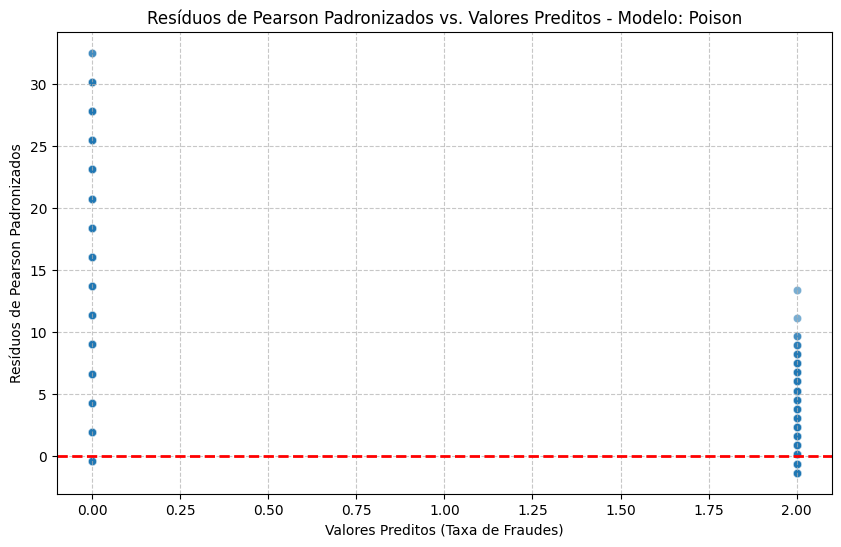

In [146]:
overdisp_plot(modelo_poison_simple, 'Poison')

In [147]:
modelo_poison_complete = smf.glm(formula=features_completa_formula, data=X, family=sm.families.Poisson(), error='ignore').fit()
modelo_poison_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                28722
Model:                            GLM   Df Residuals:                    28673
Model Family:                 Poisson   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20124.
Date:                Thu, 05 Jun 2025   Deviance:                       27824.
Time:                        18:32:09   Pearson chi2:                 7.44e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5932
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  18.9847      4.241      4.476      0.000      10.672      27.297
total_amount                                0.0002   3.48e-06     47.956      0.000       0.000       0.000
mean_amount                                -0.0573      0.002    -27.336      0.000      -0.061      -0.053
max_amount                               3.379e-05   2.51e-05      1.348      0.178   -1.53e-05    8.29e-05
mean_current_age                            0.0345      0.013      2.604      0.009       0.009       0.060
max_current_age                            -0.0427      0.004    -11.670      0.000      -0.050      -0.036
min_current_age                             0.0768      0.008      9.327      0.000       0.061       0.093
mean_per_capita_income                   3.559e-05   2.24e-05      1.592      0.111   -8.23e-06    7.94e-05
max_per_capita_income                   -2.642e-06   3.49e-07     -7.578      0.000   -3.33e-06   -1.96e-06
min_per_capita_income                   -9.337e-07   3.23e-06     -0.289      0.773   -7.27e-06    5.41e-06
mean_total_debt                          1.572e-06    4.1e-06      0.383      0.702   -6.47e-06    9.61e-06
max_total_debt                          -4.971e-08   1.06e-07     -0.469      0.639   -2.57e-07    1.58e-07
min_total_debt                            4.57e-05   2.31e-05      1.979      0.048    4.47e-07    9.09e-05
mean_credit_score                          -0.0233      0.003     -8.610      0.000      -0.029      -0.018
max_credit_score                           -0.0005      0.004     -0.120      0.904      -0.009       0.008
min_credit_score                            0.0039      0.001      4.332      0.000       0.002       0.006
mean_num_credit_cards                       0.9628      0.127      7.554      0.000       0.713       1.213
max_num_credit_cards                       -0.0409      0.020     -2.089      0.037      -0.079      -0.003
min_num_credit_cards                       -0.0693      0.384     -0.181      0.857      -0.822       0.683
mean_credit_limit                       -1.261e-05   2.15e-05     -0.586      0.558   -5.48e-05    2.96e-05
max_credit_limit                         3.136e-07   3.53e-07      0.888      0.374   -3.78e-07    1.01e-06
use_chip_swipe_transaction                 -0.6312      0.040    -15.622      0.000      -0.710      -0.552
gender_female                               2.9089      0.338      8.615      0.000       2.247       3.571
card_brand_amex                            -1.7696      0.748     -2.366      0.018      -3.236      -0.304
card_brand_mastercard                       2.3432      0.365      6.415      0.000       1.627       3.059
card_brand_discover                         6.1723      1.0

In [148]:
overdisp(modelo_poison_complete, df)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.002      
Dependent Variable:     ystar            AIC:                         246124.5280
Date:                   2025-06-05 18:32 BIC:                         246132.7935
No. Observations:       28722            Log-Likelihood:              -1.2306e+05
Df Model:               1                F-statistic:                 53.27      
Df Residuals:           28721            Prob (F-statistic):          2.98e-13   
R-squared (uncentered): 0.002            Scale:                       308.37     
---------------------------------------------------------------------------------------
              Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda         0.7674         0.1051       7.2989       0.0000       0.5613    

O teste de superdispersão indica que existe indicios de superdisperção com 95% de confiança

Aplicando o processo stepwise afim de identificar se a melhor seleção de features ajuda a resolver o problema de superdispersão.

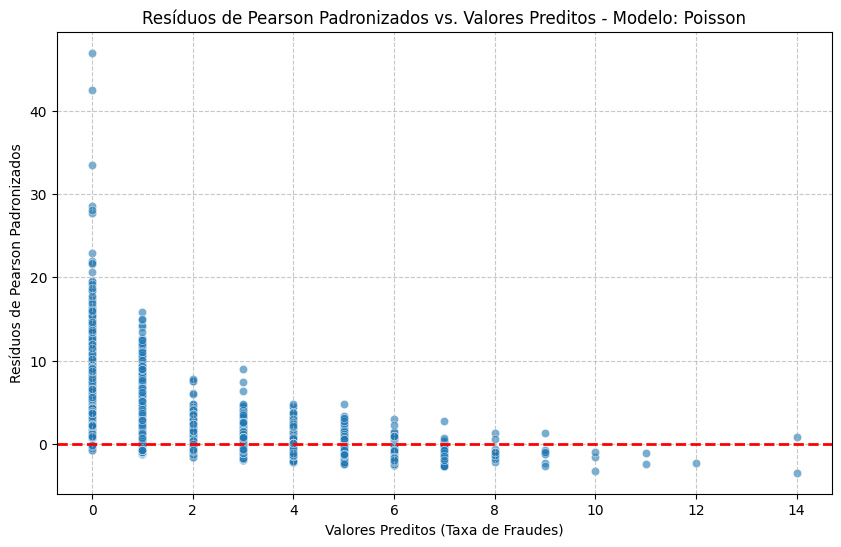

In [149]:
overdisp_plot(modelo_poison_complete, 'Poisson')

In [150]:
modelo_poisson_stepswise = stepwise(modelo_poison_complete, pvalue_limit=0.05)
modelo_poisson_stepswise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('mean_amount') + Q('max_amount') + Q('mean_current_age') + Q('max_current_age') + Q('min_current_age') + Q('mean_per_capita_income') + Q('max_per_capita_income') + Q('min_per_capita_income') + Q('mean_total_debt') + Q('max_total_debt') + Q('min_total_debt') + Q('mean_credit_score') + Q('max_credit_score') + Q('min_credit_score') + Q('mean_num_credit_cards') + Q('max_num_credit_cards') + Q('min_num_credit_cards') + Q('mean_credit_limit') + Q('max_credit_limit') + Q('use_chip_swipe_transaction') + Q('gender_female') + Q('card_brand_amex') + Q('card_brand_mastercard') + Q('card_brand_discover') + Q('card_type_debit') + Q('card_type_debit_prepaid') + Q('has_chip_yes') + Q('online_sales_no') + Q('has_error_yes') + Q('category_travel_hospitality') + Q('category_government_utilities') + Q('category_retail_general_department') + Q('category_transportation_logistics') + Q('category_retail_clothing_accessories') + Q('ca

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                28722
Model:                            GLM   Df Residuals:                    28687
Model Family:                 Poisson   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20130.
Date:                Thu, 05 Jun 2025   Deviance:                       27836.
Time:                        18:33:00   Pearson chi2:                 7.36e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5930
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       19.1611      1.940      9.879      0.000      15.360      22.963
Q('total_amount')                                0.0002      3e-06     55.734      0.000       0.000       0.000
Q('mean_amount')                                -0.0554      0.001    -50.973      0.000      -0.058      -0.053
Q('mean_current_age')                            0.0332      0.012      2.815      0.005       0.010       0.056
Q('max_current_age')                            -0.0418      0.004    -11.595      0.000      -0.049      -0.035
Q('min_current_age')                             0.0763      0.008      9.378      0.000       0.060       0.092
Q('mean_per_capita_income')                   3.494e-05   1.54e-05      2.271      0.023    4.78e-06    6.51e-05
Q('max_per_capita_income')                   -2.566e-06   3.27e-07     -7.856      0.000   -3.21e-06   -1.93e-06
Q('mean_credit_score')                          -0.0233      0.003     -8.771      0.000      -0.029      -0.018
Q('min_credit_score')                            0.0040      0.001      4.473      0.000       0.002       0.006
Q('mean_num_credit_cards')                       0.9506      0.126      7.553      0.000       0.704       1.197
Q('max_num_credit_cards')                       -0.0383      0.019     -1.978      0.048      -0.076      -0.000
Q('use_chip_swipe_transaction')                 -0.6281      0.040    -15.668      0.000      -0.707      -0.549
Q('gender_female')                               2.9121      0.332      8.763      0.000       2.261       3.563
Q('card_brand_amex')                            -1.7753      0.746     -2.381      0.017      -3.237      -0.314
Q('card_brand_mastercard')                       2.3418      0.362      6.464      0.000       1.632       3.052
Q('card_brand_discover')                         6.0783      1.043      5.829      0.000       4.034       8.122
Q('card_type_debit')                            -2.7076      0.406     -6.666      0.000      -3.504      -1.912
Q('card_type_debit_prepaid')                     4.1976      0.668      6.283      0.000       2.888       5.507
Q('online_sales_no')                           -12.5735      0.497    -25.285      0.000     -13.548     -11.599
Q('category_government_utilities')              -4.9457      0.950     -5.204      0.000      -6.808      -3.083
Q('category_retail_general_department')          2.2006      0.609      3.616      0.000       1.008       3.393
Q('category_transportation_logistics')          -4.7158      0.509     -9.256      0.000      -5.714      -3.717
Q('category_retail_clothing_accessories')        7.2208      1.514      4.770      0.000       4.254      10.188
Q('category_retail_specialty')  

Aplicando a analise de superdispersão e a "plotagem" do gráfico de valores preditos X os residuos ajustados para comparar como o modelo se comporta em relação a superdispersão.

In [151]:
overdisp(modelo_poisson_stepswise, X)

Estimating model...: 
 GLM
                         Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.002      
Dependent Variable:     ystar            AIC:                         245374.8090
Date:                   2025-06-05 18:33 BIC:                         245383.0744
No. Observations:       28722            Log-Likelihood:              -1.2269e+05
Df Model:               1                F-statistic:                 54.88      
Df Residuals:           28721            Prob (F-statistic):          1.32e-13   
R-squared (uncentered): 0.002            Scale:                       300.42     
---------------------------------------------------------------------------------------
              Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
---------------------------------------------------------------------------------------
lmbda         0.7691         0.1038       7.4082       0.0000       0.5656    

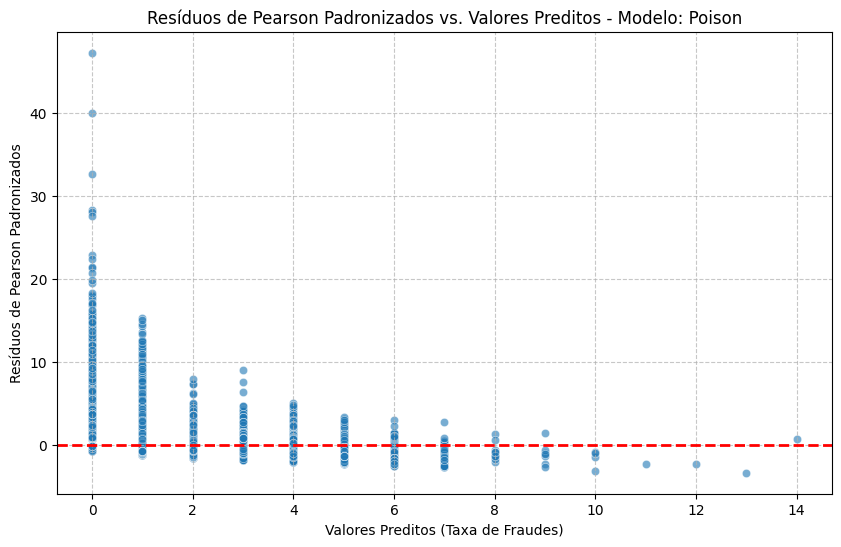

In [152]:
overdisp_plot(modelo_poisson_stepswise, 'Poison')

TODO: Rever

O gráfico evidencia uma caracteristica marcante no problema de superdispersão que é o padrão de "cone" extremamente acentuado, que se abre drasticamente quando os valores preditos se aproximam de zero. Caso o modelo fosse bem ajustado, eperariamos que os resudios estivessem distribuidos em torno de zero, sem padrões visiveis e com uma variancia mais ou menos constante.

In [153]:
summary_col([modelo_poison_simple, modelo_poison_complete, modelo_poisson_stepswise],
            model_names=["Poisson Simples", "Poisson Completo", "Poisson StepWise"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
        })

,Poisson Simples,Poisson Completo,Poisson StepWise
Intercept,-1.7103***,18.9847***,19.1611***
,(0.0151),(4.2413),(1.9396)
previous_frauds,2.3233***,2.1208***,
,(0.0186),(0.0204),
total_amount,,0.0002***,
,,(0.0000),
mean_amount,,-0.0573***,
,,(0.0021),
max_amount,,0.0000,
,,(0.0000),


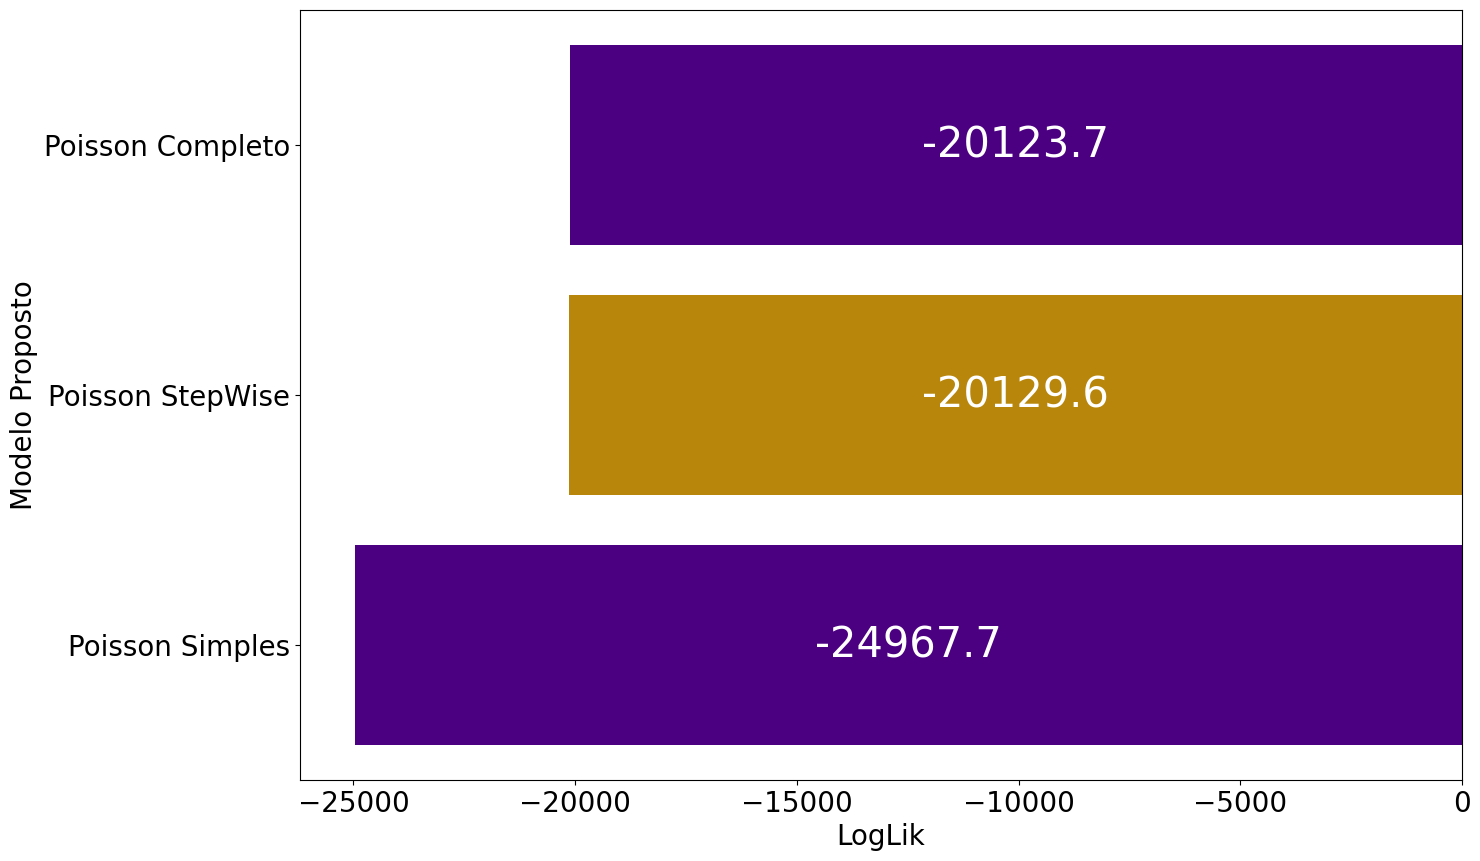

In [154]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf]
})

### Binomial Negative (Poisson-Gama)

In [155]:
result_tests = {}
for column in X.drop(columns=['frauds']).columns[1:]:
  model_test = smf.glm(formula=f'frauds ~ {column}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
  result_tests[column] = model_test.llf
column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [156]:
modelo_binomialneg_simples = smf.glm(formula=f'frauds ~ {column_max}', data=X, family=sm.families.NegativeBinomial()).fit(disp=True)
modelo_binomialneg_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                28722
Model:                            GLM   Df Residuals:                    28720
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20672.
Date:                Thu, 05 Jun 2025   Deviance:                       22906.
Time:                        18:33:03   Pearson chi2:                 8.96e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2953
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.7103      0.016   -103.959      0.000      -1.742      -1.678
previous_frauds     2.3233      0.025     94.354      0.000       2.275       2.372
===================================================================================
"""

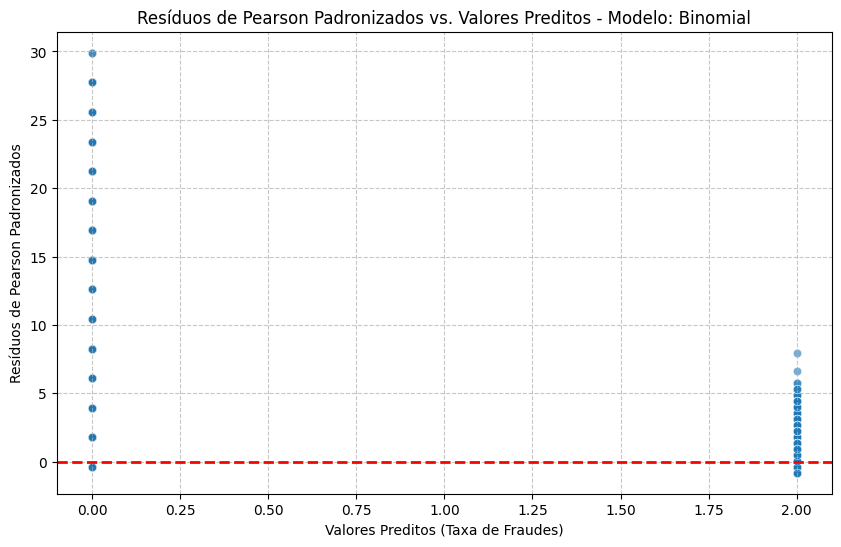

In [157]:
overdisp_plot(modelo_binomialneg_simples, 'Binomial')

In [158]:
modelo_binomialneg_completo = smf.glm(formula=features_completa_formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomialneg_completo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                28722
Model:                            GLM   Df Residuals:                    28673
Model Family:        NegativeBinomial   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17535.
Date:                Thu, 05 Jun 2025   Deviance:                       16633.
Time:                        18:33:03   Pearson chi2:                 5.94e+04
No. Iterations:                    13   Pseudo R-squ. (CS):             0.4336
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  22.3794      4.904      4.563      0.000      12.767      31.992
total_amount                                0.0002   5.05e-06     36.144      0.000       0.000       0.000
mean_amount                                -0.0588      0.003    -17.820      0.000      -0.065      -0.052
max_amount                               2.401e-05   3.94e-05      0.610      0.542   -5.32e-05       0.000
mean_current_age                            0.0512      0.019      2.738      0.006       0.015       0.088
max_current_age                            -0.0572      0.005    -11.321      0.000      -0.067      -0.047
min_current_age                             0.0983      0.012      8.480      0.000       0.076       0.121
mean_per_capita_income                   8.785e-05   3.14e-05      2.797      0.005    2.63e-05       0.000
max_per_capita_income                    -3.74e-06   5.31e-07     -7.041      0.000   -4.78e-06    -2.7e-06
min_per_capita_income                   -3.212e-06   4.49e-06     -0.716      0.474    -1.2e-05    5.58e-06
mean_total_debt                         -1.234e-06   5.72e-06     -0.216      0.829   -1.24e-05    9.97e-06
max_total_debt                          -1.448e-07   1.64e-07     -0.883      0.377   -4.66e-07    1.77e-07
min_total_debt                           3.109e-05   4.72e-05      0.659      0.510   -6.14e-05       0.000
mean_credit_score                          -0.0274      0.004     -7.282      0.000      -0.035      -0.020
max_credit_score                           -0.0002      0.005     -0.048      0.962      -0.009       0.009
min_credit_score                            0.0031      0.001      2.700      0.007       0.001       0.005
mean_num_credit_cards                       0.9743      0.178      5.461      0.000       0.625       1.324
max_num_credit_cards                       -0.0374      0.029     -1.271      0.204      -0.095       0.020
min_num_credit_cards                        0.0626      0.399      0.157      0.876      -0.720       0.845
mean_credit_limit                        2.075e-06   3.02e-05      0.069      0.945   -5.72e-05    6.13e-05
max_credit_limit                         5.847e-08   5.37e-07      0.109      0.913   -9.94e-07    1.11e-06
use_chip_swipe_transaction                 -0.7072      0.058    -12.146      0.000      -0.821      -0.593
gender_female                               3.7286      0.457      8.158      0.000       2.833       4.624
card_brand_amex                            -2.7491      1.043     -2.637      0.008      -4.793      -0.705
card_brand_mastercard                       2.5665      0.506      5.072      0.000       1.575       3.558
card_brand_discover                         6.8738      1.4

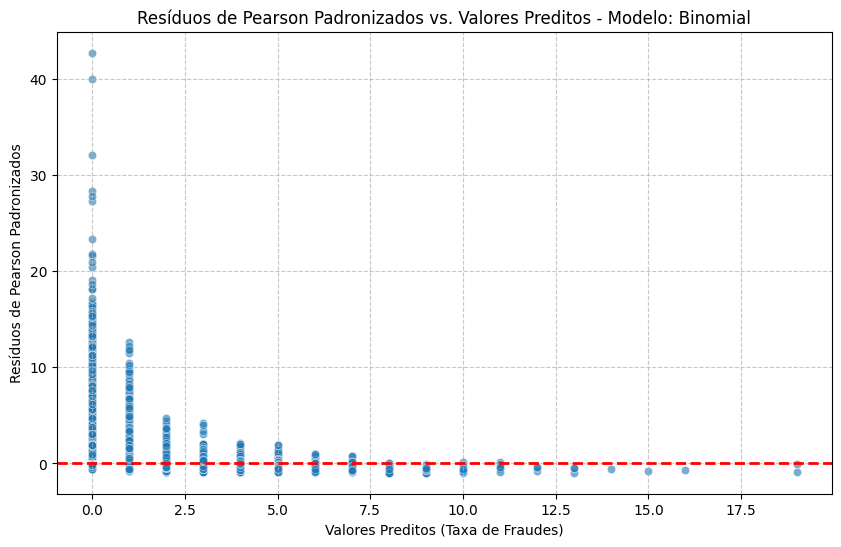

In [159]:
overdisp_plot(modelo_binomialneg_completo, 'Binomial')

In [160]:
modelo_binomialneg_stepwise = stepwise(modelo_binomialneg_completo, pvalue_limit=0.05)
modelo_binomialneg_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_amount') + Q('mean_amount') + Q('max_amount') + Q('mean_current_age') + Q('max_current_age') + Q('min_current_age') + Q('mean_per_capita_income') + Q('max_per_capita_income') + Q('min_per_capita_income') + Q('mean_total_debt') + Q('max_total_debt') + Q('min_total_debt') + Q('mean_credit_score') + Q('max_credit_score') + Q('min_credit_score') + Q('mean_num_credit_cards') + Q('max_num_credit_cards') + Q('min_num_credit_cards') + Q('mean_credit_limit') + Q('max_credit_limit') + Q('use_chip_swipe_transaction') + Q('gender_female') + Q('card_brand_amex') + Q('card_brand_mastercard') + Q('card_brand_discover') + Q('card_type_debit') + Q('card_type_debit_prepaid') + Q('has_chip_yes') + Q('online_sales_no') + Q('has_error_yes') + Q('category_travel_hospitality') + Q('category_government_utilities') + Q('category_retail_general_department') + Q('category_transportation_logistics') + Q('category_retail_clothing_accessories') + Q('ca

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                28722
Model:                            GLM   Df Residuals:                    28688
Model Family:        NegativeBinomial   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17539.
Date:                Thu, 05 Jun 2025   Deviance:                       16640.
Time:                        18:33:11   Pearson chi2:                 5.94e+04
No. Iterations:                     9   Pseudo R-squ. (CS):             0.4334
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       21.3100      2.821      7.553      0.000      15.780      26.840
Q('total_amount')                                0.0002   4.45e-06     41.095      0.000       0.000       0.000
Q('mean_amount')                                -0.0586      0.003    -20.285      0.000      -0.064      -0.053
Q('mean_current_age')                            0.0519      0.017      3.072      0.002       0.019       0.085
Q('max_current_age')                            -0.0584      0.005    -11.753      0.000      -0.068      -0.049
Q('min_current_age')                             0.0982      0.011      8.555      0.000       0.076       0.121
Q('mean_per_capita_income')                   8.195e-05    2.2e-05      3.727      0.000    3.88e-05       0.000
Q('max_per_capita_income')                   -3.727e-06   4.96e-07     -7.507      0.000    -4.7e-06   -2.75e-06
Q('mean_credit_score')                          -0.0274      0.004     -7.380      0.000      -0.035      -0.020
Q('min_credit_score')                            0.0033      0.001      2.878      0.004       0.001       0.005
Q('mean_num_credit_cards')                       0.9581      0.175      5.464      0.000       0.614       1.302
Q('use_chip_swipe_transaction')                 -0.7021      0.058    -12.153      0.000      -0.815      -0.589
Q('gender_female')                               3.7559      0.450      8.341      0.000       2.873       4.638
Q('card_brand_amex')                            -2.7653      1.040     -2.659      0.008      -4.804      -0.727
Q('card_brand_mastercard')                       2.5998      0.503      5.169      0.000       1.614       3.586
Q('card_brand_discover')                         6.8448      1.437      4.764      0.000       4.029       9.661
Q('card_type_debit')                            -3.8137      0.569     -6.705      0.000      -4.928      -2.699
Q('card_type_debit_prepaid')                     3.5563      0.943      3.772      0.000       1.708       5.404
Q('online_sales_no')                           -12.4479      0.710    -17.534      0.000     -13.839     -11.056
Q('category_government_utilities')              -4.3055      1.282     -3.359      0.001      -6.818      -1.793
Q('category_retail_general_department')          1.8700      0.855      2.187      0.029       0.194       3.546
Q('category_transportation_logistics')          -5.6307      0.746     -7.547      0.000      -7.093      -4.168
Q('category_retail_clothing_accessories')       10.0770      2.113      4.768      0.000       5.935      14.219
Q('category_retail_specialty')                   9.5591      1.267      7.543      0.000       7.075      12.043
Q('category_arts_entertainment_r

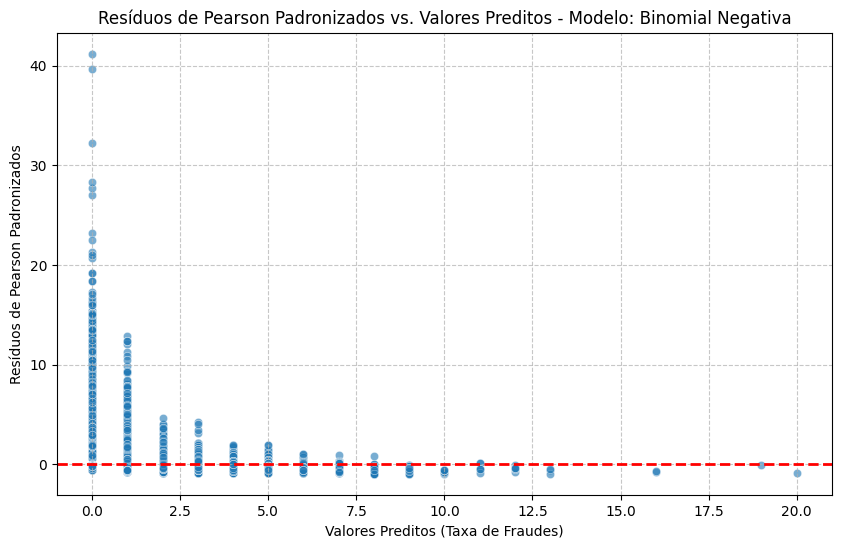

In [161]:
overdisp_plot(modelo_binomialneg_stepwise, 'Binomial Negativa')

In [162]:
lrtest([modelo_binomialneg_completo, modelo_binomialneg_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -6.79
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


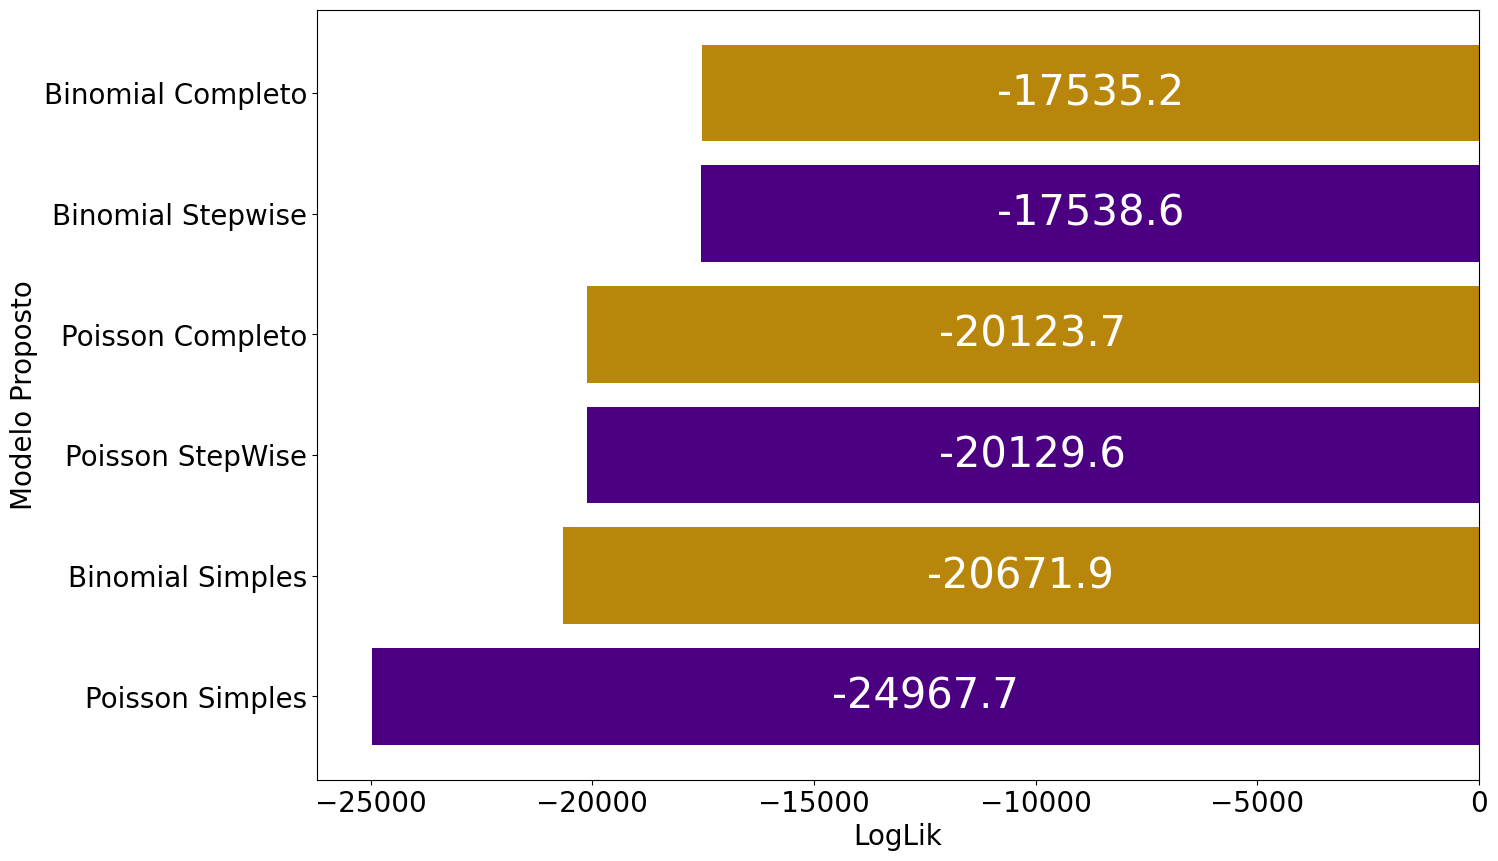

In [163]:
compare_models({
    'modelo':['Poisson Simples', 'Poisson Completo', 'Poisson StepWise', 'Binomial Simples', 'Binomial Completo', 'Binomial Stepwise'],
    'loglik':[modelo_poison_simple.llf, modelo_poison_complete.llf, modelo_poisson_stepswise.llf, modelo_binomialneg_simples.llf, modelo_binomialneg_completo.llf, modelo_binomialneg_stepwise.llf]
})

### Zero Inflated Poison

In [164]:
X_log = X.drop(columns=['frauds']).copy()
for column in X_log.columns:
  X_log[column] = np.log(X_log[column] + 1)
X_log.head()

,total_amount,mean_amount,max_amount,mean_current_age,max_current_age,min_current_age,mean_per_capita_income,max_per_capita_income,min_per_capita_income,mean_total_debt,...,category_arts_entertainment_recreation,category_professional_business_services,category_food_beverage,category_technology_telecommunications,category_sports_recreation,category_retail_home_garden,category_construction_contractors,category_manufacturing_industrial,category_personal_services,previous_frauds
0,7.984234,3.758982,5.602930,4.003169,4.624973,3.433987,10.069148,10.921667,0.000000,11.086597,...,0.009950,0.00995,0.357674,0.009950,0.000000,0.00000,0.0,0.000000,0.0,0.0
1,7.739760,3.638825,5.178633,4.035952,4.477337,3.465736,9.960689,10.583169,9.006509,10.824636,...,0.019803,0.00000,0.364643,0.048790,0.048790,0.00000,0.0,0.000000,0.0,0.0
2,9.452093,3.607394,7.051518,4.028867,4.624973,3.367296,10.087207,11.830863,0.000000,10.949803,...,0.009950,0.00000,0.378436,0.029559,0.019803,0.00000,0.0,0.000000,0.0,0.0
3,9.680742,3.582024,5.794628,4.040865,4.595120,3.433987,10.090327,11.462053,0.000000,10.942104,...,0.019803,0.00000,0.418710,0.019803,0.009950,0.00995,0.0,0.000000,0.0,0.0
4,9.941814,3.889391,6.630934,4.063656,4.595120,3.367296,10.084823,12.002401,0.000000,10.851244,...,0.019803,0.00000,0.385262,0.019803,0.009950,0.00995,0.0,0.019803,0.0,0.0


In [165]:
exclude_columns = X_log.isna().sum().reset_index().rename(columns={0:'missing'}).query('missing > 0')['index'].to_list()
X_droped = X.drop(columns=exclude_columns)

In [166]:
standard_scaler = StandardScaler()
X_scaler = standard_scaler.fit_transform(X_droped.drop(columns=['frauds']))

X_scaler = pd.DataFrame(X_scaler, columns=X_droped.drop(columns=['frauds']).columns)
X_scaler.head()

,total_amount,mean_amount,max_amount,mean_current_age,max_current_age,min_current_age,mean_per_capita_income,max_per_capita_income,min_per_capita_income,mean_total_debt,...,category_arts_entertainment_recreation,category_professional_business_services,category_food_beverage,category_technology_telecommunications,category_sports_recreation,category_retail_home_garden,category_construction_contractors,category_manufacturing_industrial,category_personal_services,previous_frauds
0,-1.559836,-0.751965,-1.073775,-0.122406,1.031765,1.644539,-0.214542,-1.197936,-0.671962,1.806531,...,-0.411482,0.187650,1.090587,-0.942163,-0.614772,-1.747045,-0.087748,-0.625719,-1.069697,-0.436293
1,-1.642728,-1.050645,-1.313805,1.226166,-1.940780,2.093591,-2.783850,-1.608005,0.984098,-1.883990,...,-0.018446,-0.755427,1.247941,0.272143,6.482284,-1.747045,-0.087748,-0.625719,-1.069697,-0.436293
2,-0.283342,-1.123031,1.187264,0.930946,1.031765,0.746435,0.240997,0.918855,-0.671962,-0.240832,...,-0.411482,-0.755427,1.562647,-0.335010,2.224051,-1.747045,-0.087748,-0.625719,-1.069697,-0.436293
3,0.142776,-1.179821,-0.927090,1.432123,0.394791,1.644539,0.320527,-0.174517,-0.671962,-0.347954,...,-0.018446,-0.755427,2.506767,-0.638587,0.804639,-1.125830,-0.087748,-0.625719,-1.069697,-0.436293
4,0.764716,-0.384495,0.172626,2.400761,0.394791,0.746435,0.180367,1.582193,-0.671962,-1.551692,...,-0.018446,-0.755427,1.720000,-0.638587,0.804639,-1.125830,-0.087748,0.761216,-1.069697,-0.436293


In [167]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zip_test = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
  result_tests[column] = modelo_zip_test.llf

column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'previous_frauds'

In [168]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [169]:
modelo_zip_simples = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
modelo_zip_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                28722
Model:             ZeroInflatedPoisson   Df Residuals:                    28720
Method:                            MLE   Df Model:                            1
Date:                 Thu, 05 Jun 2025   Pseudo R-squ.:                  0.1498
Time:                         18:33:37   Log-Likelihood:                -18537.
converged:                        True   LL-Null:                       -21802.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
inflate_const               1.9112      0.022     88.742      0.000       1.869       1.953
inflate_previous_frauds    -1.1001      0.015    -72.001      0.000      -1.130      -1.070
const                       0.8130      0.015     55.020      0.000       0.784       0.842
previous_frauds             0.1020      0.008     13.227      0.000       0.087       0.117
===========================================================================================
"""

In [170]:
vuong_test(modelo_poison_simple, modelo_zip_simples)

Optimization terminated successfully.
         Current function value: 0.869288
         Iterations 8
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -26.592
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [171]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [172]:
modelo_zip_complete = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False)
modelo_zip_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                28722
Model:             ZeroInflatedPoisson   Df Residuals:                    28673
Method:                            MLE   Df Model:                           48
Date:                 Thu, 05 Jun 2025   Pseudo R-squ.:                  0.2539
Time:                         18:33:43   Log-Likelihood:                -16267.
converged:                       False   LL-Null:                       -21802.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.7979      0.033     55.171      0.000       1.734       1.862
inflate_total_amount                               -0.6253      0.067     -9.324      0.000      -0.757      -0.494
inflate_mean_amount                                 0.1829      0.090      2.035      0.042       0.007       0.359
inflate_max_amount                                  0.0194      0.028      0.697      0.486      -0.035       0.074
inflate_mean_current_age                           -0.1393      0.042     -3.321      0.001      -0.222      -0.057
inflate_max_current_age                             0.3139      0.040      7.831      0.000       0.235       0.392
inflate_min_current_age                            -0.1898      0.044     -4.338      0.000      -0.276      -0.104
inflate_mean_per_capita_income                     -0.1449      0.050     -2.890      0.004      -0.243      -0.047
inflate_max_per_capita_income                       0.1772      0.036      4.858      0.000       0.106       0.249
inflate_min_per_capita_income                       0.0531      0.037      1.430      0.153      -0.020       0.126
inflate_mean_total_debt                             0.0722      0.039      1.867      0.062      -0.004       0.148
inflate_max_total_debt                             -0.0178      0.032     -0.548      0.584      -0.081       0.046
inflate_min_total_debt                             -0.0662      0.124     -0.535      0.593      -0.309       0.177
inflate_mean_credit_score                           0.1781      0.035      5.032      0.000       0.109       0.248
inflate_max_credit_score                            0.2073      0.043      4.794      0.000       0.123       0.292
inflate_min_credit_score                            0.0808      0.042      1.916      0.055      -0.002       0.163
inflate_mean_num_credit_cards                      -0.0472      0.038     -1.250      0.211      -0.121       0.027
inflate_max_num_credit_cards                       -0.0101      0.029     -0.350      0.727      -0.067       0.047
inflate_min_num_credit_cards                       -0.0284      0.038     -0.742      0.458      -0.103       0.047
inflate_mean_credit_limit                          -0.0011      0.046     -0.023      0.981      -0.092       0.090
inflate_max_credit_limit                            0.0237      0.032      0.735      0.462      -0.039       0.087
inflate_use_chip_swipe_transaction                  0.2883      0.036      8.101      0.000       0.219       0.358
inflate_gender_female                              -0.1872      0.033     -5.666      0.000      -0.252      -0.122
inflate_card_brand_amex                             0.0500      0.035      1.423      0.155      -0.019       0.119
inflate_card_brand_mastercard                      -0.0783      0.034     -2.330      0.020      -0.

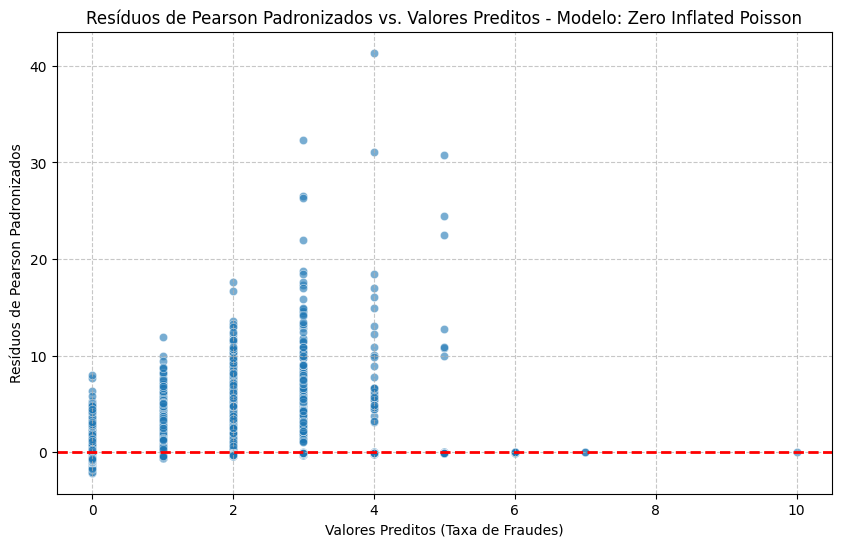

In [173]:
overdisp_plot(modelo_zip_complete, 'Zero Inflated Poisson')

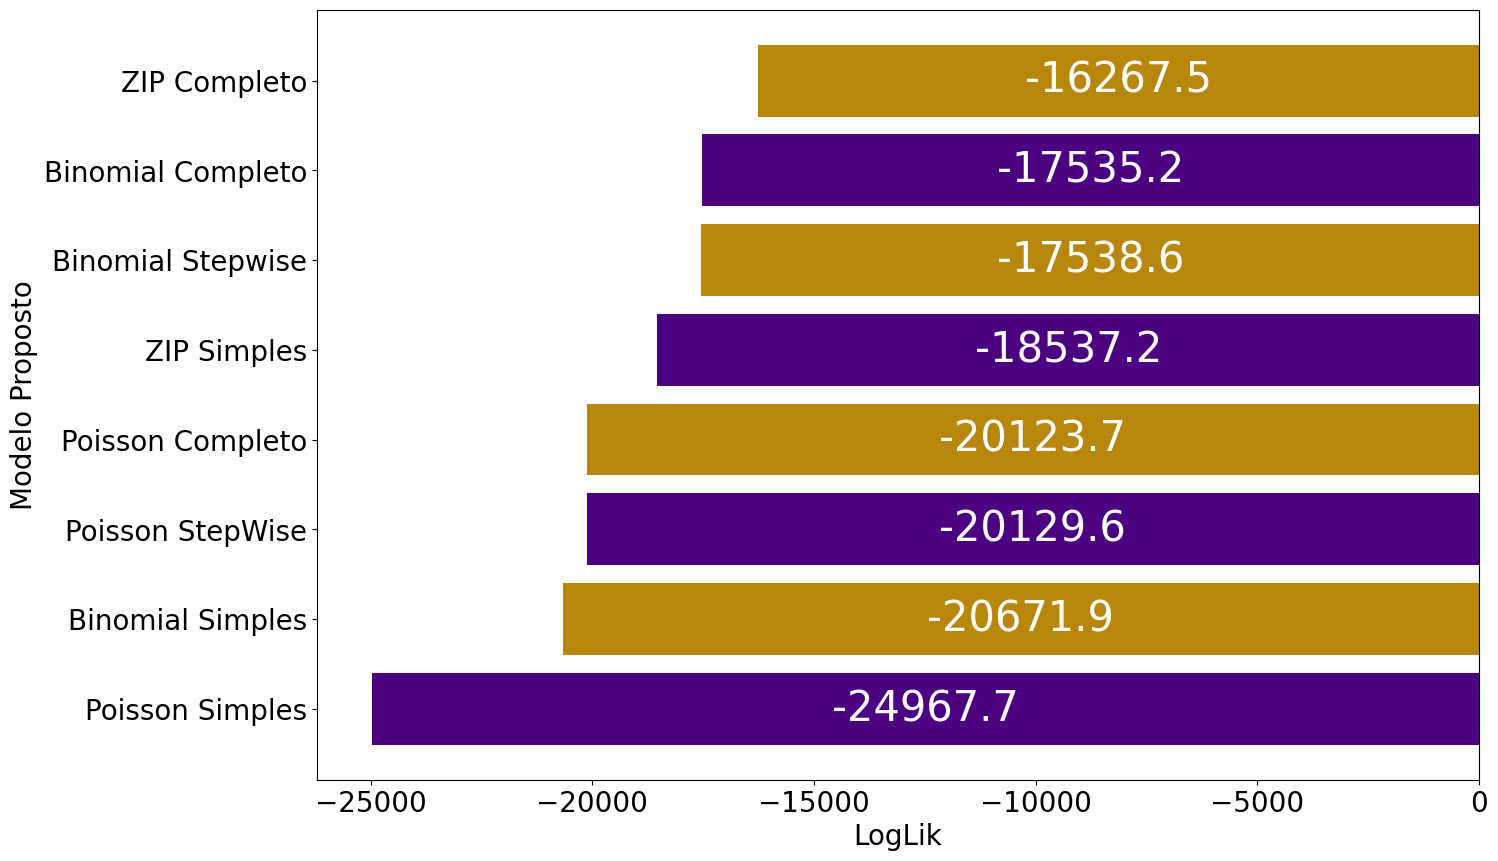

In [174]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf
      ]
})

In [175]:
df_features_zip_complete = modelo_zip_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x!='const', df_features_zip_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x!='const', df_features_zip_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['total_amount', 'mean_amount', 'max_amount', 'min_current_age', 'max_per_capita_income', 'max_credit_score', 'min_credit_score', 'mean_num_credit_cards', 'use_chip_swipe_transaction', 'gender_female', 'card_brand_mastercard', 'card_brand_discover', 'card_type_debit_prepaid', 'online_sales_no', 'category_government_utilities', 'category_transportation_logistics', 'category_retail_specialty', 'category_retail_home_garden', 'category_manufacturing_industrial', 'category_personal_services', 'previous_frauds']
Exogenas Inflado
['total_amount', 'mean_amount', 'mean_current_age', 'max_current_age', 'min_current_age', 'mean_per_capita_income', 'max_per_capita_income', 'mean_credit_score', 'max_credit_score', 'use_chip_swipe_transaction', 'gender_female', 'card_brand_mastercard', 'card_type_debit', 'category_retail_clothing_accessories', 'category_arts_entertainment_recreation', 'category_professional_business_services', 'category_retail_home_garden', 'previous_frauds']


In [176]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zip_complete_filter = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2).fit(disp=False)
modelo_zip_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                28722
Model:             ZeroInflatedPoisson   Df Residuals:                    28700
Method:                            MLE   Df Model:                           21
Date:                 Thu, 05 Jun 2025   Pseudo R-squ.:                  0.2528
Time:                         18:33:46   Log-Likelihood:                -16290.
converged:                       False   LL-Null:                       -21802.
Covariance Type:             nonrobust   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       1.9281      0.031     62.002      0.000       1.867       1.989
inflate_total_amount                               -0.7520      0.043    -17.635      0.000      -0.836      -0.668
inflate_mean_amount                                 0.2644      0.055      4.824      0.000       0.157       0.372
inflate_mean_current_age                           -0.1771      0.033     -5.374      0.000      -0.242      -0.112
inflate_max_current_age                             0.3772      0.038     10.014      0.000       0.303       0.451
inflate_min_current_age                            -0.1965      0.042     -4.670      0.000      -0.279      -0.114
inflate_mean_per_capita_income                     -0.0684      0.034     -2.028      0.043      -0.134      -0.002
inflate_max_per_capita_income                       0.2048      0.033      6.133      0.000       0.139       0.270
inflate_mean_credit_score                           0.1685      0.031      5.448      0.000       0.108       0.229
inflate_max_credit_score                            0.1749      0.040      4.414      0.000       0.097       0.253
inflate_use_chip_swipe_transaction                  0.2696      0.034      7.921      0.000       0.203       0.336
inflate_gender_female                              -0.2040      0.031     -6.517      0.000      -0.265      -0.143
inflate_card_brand_mastercard                      -0.1175      0.031     -3.792      0.000      -0.178      -0.057
inflate_card_type_debit                             0.1819      0.031      5.934      0.000       0.122       0.242
inflate_category_retail_clothing_accessories       -0.1077      0.027     -4.006      0.000      -0.160      -0.055
inflate_category_arts_entertainment_recreation      0.4356      0.036     11.993      0.000       0.364       0.507
inflate_category_professional_business_services     0.1865      0.035      5.373      0.000       0.118       0.255
inflate_category_retail_home_garden                 0.0930      0.031      3.019      0.003       0.033       0.153
inflate_previous_frauds                            -1.2307      0.022    -56.824      0.000      -1.273      -1.188
const                                               0.1216      0.022      5.492      0.000       0.078       0.165
total_amount                                        0.7908      0.026     30.962      0.000       0.741       0.841
mean_amount                                        -0.7294      0.034    -21.386      0.000      -0.796      -0.663
max_amount                                          0.0408      0.010      3.995      0.000       0.021       0.061
min_current_age                                     0.0460      0.020      2.319      0.020       0.007       0.085
max_per_capita_income                              -0.0385      0.013     -2.957      0.003      -0.

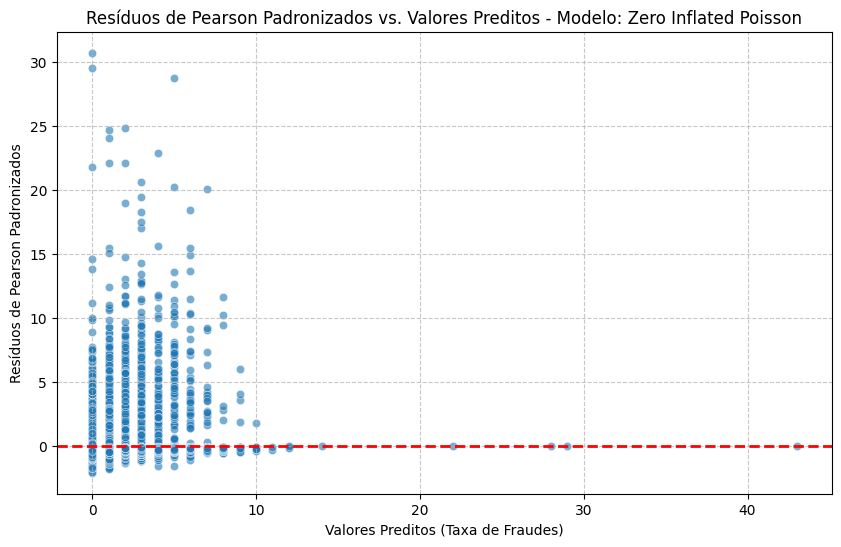

In [177]:
overdisp_plot(modelo_zip_complete_filter, 'Zero Inflated Poisson')

In [178]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='BIC',
    verbose=False,
    validation_steps=False,
    fit_params=dict(disp=False),
    batch_size=8,
    early_stopping=False,
    parallel_features=True,
    n_jobs=4,
    suppress_warnings='all')
step_wise.fit(X_scaler, y)

Stepwise Selection:   0%|          | 0/100 [00:00<?, ?iter/s]

StepwiseZeroInflated(batch_size=8, early_stopping=False,
                     fit_params={'disp': False}, model_params={}, n_jobs=4,
                     parallel_features=True, selection_criterion='BIC',
                     validation_steps=False)

In [179]:
modelo_zip_stepwise = step_wise.final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                28722
Model:             ZeroInflatedPoisson   Df Residuals:                    28710
Method:                            MLE   Df Model:                           11
Date:                 Thu, 05 Jun 2025   Pseudo R-squ.:                  0.2423
Time:                         22:06:54   Log-Likelihood:                -16520.
converged:                       False   LL-Null:                       -21802.
Covariance Type:             nonrobust   LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
inflate_const                                    2.0392      0.031     65.547      0.000       1.978       2.100
inflate_previous_frauds                         -1.3066      0.022    -58.915      0.000      -1.350      -1.263
inflate_total_amount                            -0.9633      0.044    -21.774      0.000      -1.050      -0.877
inflate_mean_amount                              0.4019      0.064      6.315      0.000       0.277       0.527
inflate_online_sales_no                          0.0805      0.041      1.972      0.049       0.000       0.160
inflate_max_current_age                          0.4150      0.038     10.969      0.000       0.341       0.489
inflate_category_retail_specialty               -0.2226      0.031     -7.276      0.000      -0.283      -0.163
inflate_gender_female                           -0.2262      0.031     -7.218      0.000      -0.288      -0.165
inflate_max_per_capita_income                    0.2084      0.031      6.684      0.000       0.147       0.269
inflate_card_type_debit_prepaid                 -0.1794      0.032     -5.628      0.000      -0.242      -0.117
inflate_mean_current_age                        -0.2661      0.033     -8.124      0.000      -0.330      -0.202
inflate_category_government_utilities           -0.1880      0.039     -4.864      0.000      -0.264      -0.112
inflate_category_retail_clothing_accessories    -0.1257      0.027     -4.644      0.000      -0.179      -0.073
inflate_category_food_beverage                  -0.1642      0.036     -4.570      0.000      -0.235      -0.094
inflate_use_chip_swipe_transaction               0.1353      0.026      5.216      0.000       0.084       0.186
inflate_mean_credit_score                        0.1308      0.030      4.291      0.000       0.071       0.191
inflate_card_type_debit                          0.1189      0.032      3.703      0.000       0.056       0.182
const                                            0.3651      0.018     20.049      0.000       0.329       0.401
total_amount                                     0.7640      0.022     35.273      0.000       0.722       0.806
mean_amount                                     -0.5412      0.029    -18.652      0.000      -0.598      -0.484
online_sales_no                                 -0.3844      0.019    -19.742      0.000      -0.423      -0.346
category_transportation_logistics               -0.2007      0.020    -10.079      0.000      -0.240      -0.162
category_retail_specialty                        0.1020      0.015      6.760      0.000       0.072       0.132
category_government_utilities                   -0.1532      0.020     -7.722      0.000      -0.192      -0.114
mean_num_credit_cards                            0.0726      0.015      4.750      0.000       0.043       0.103
category_personal_services                      -0.0564      0.012  

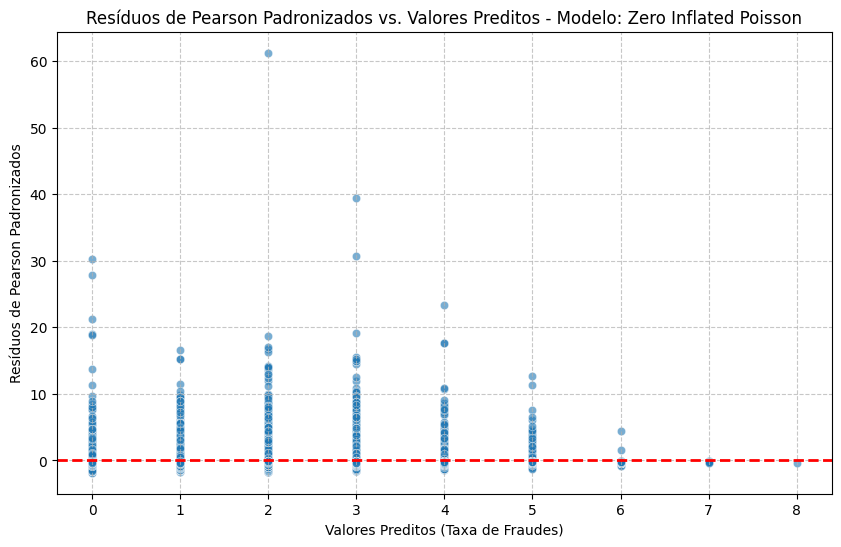

In [180]:
overdisp_plot(modelo_zip_stepwise, 'Zero Inflated Poisson')

In [181]:
lrtest([modelo_zip_stepwise, modelo_zip_stepwise])

Likelihood Ratio Test:
-2.(LL0-LLm): -0.0
p-value: 1.000

==================Result======================== 

H0: Models with log-likelihoods that are not statistically different at 95% confidence level


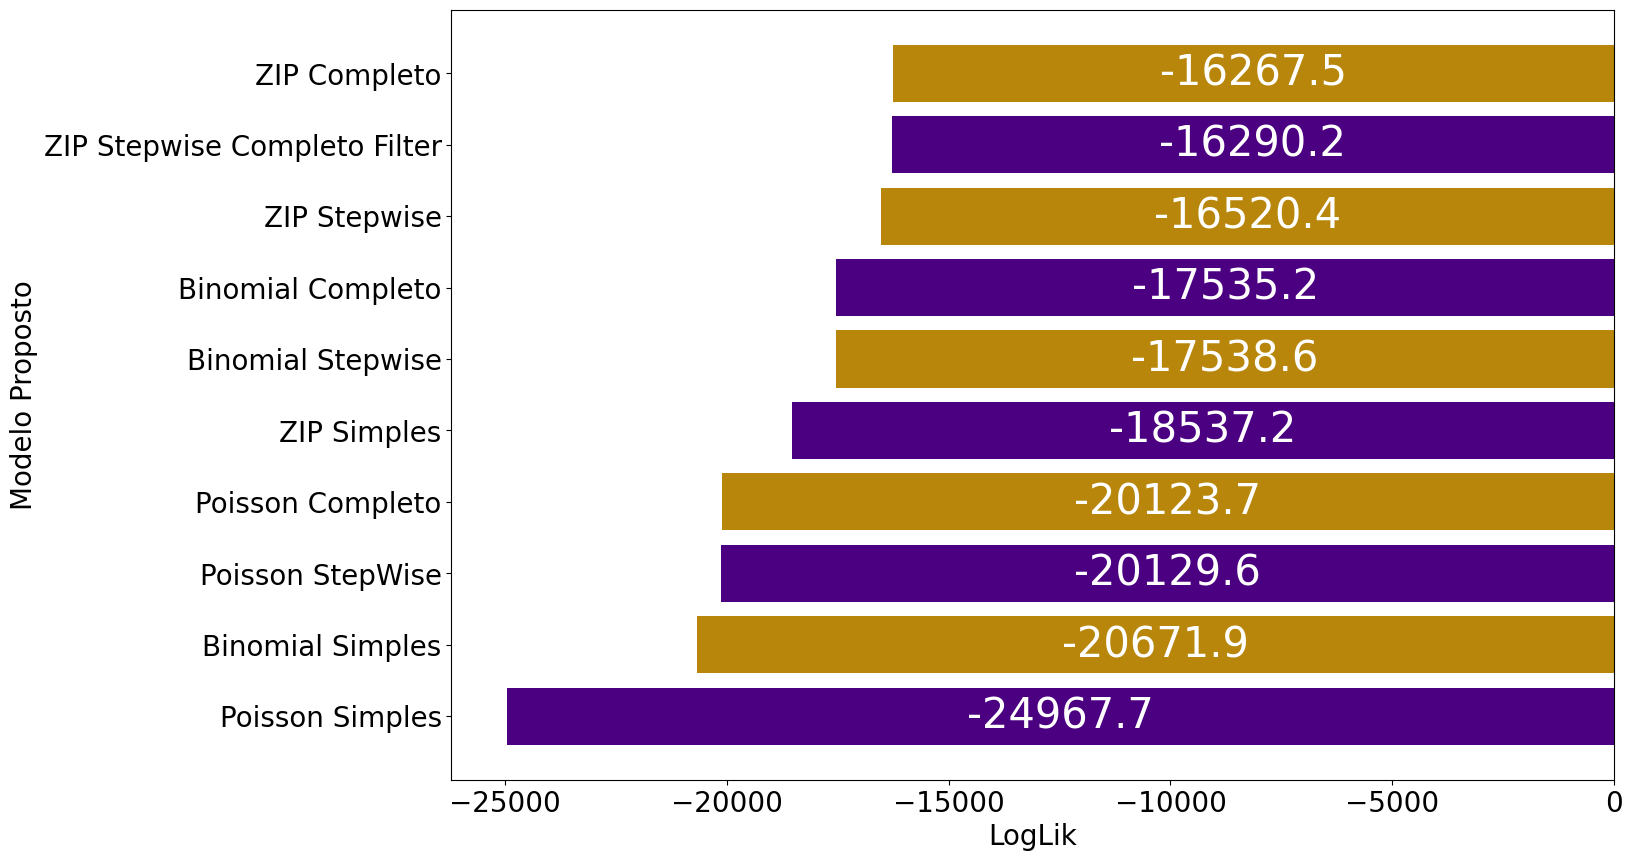

In [182]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Stepwise Completo Filter',
        'ZIP Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf
      ]
})

### ZINB - Zero Inflated Negative Benomial

In [183]:
result_tests = {}
for column in X_scaler.columns:
  X1 = X_scaler[column]
  X1 = sm.add_constant(X1)

  modelo_zbneg_test = sm.ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC1')
  result_tests[column] = modelo_zbneg_test.llf

column_max = list(result_tests.keys())[np.argmax(list(filter(lambda x: not np.isnan(x), result_tests.values())))]
column_max

'category_construction_contractors'

In [184]:
X1 = X_scaler[column_max].copy()
X1 = sm.add_constant(X1)

In [185]:
modelo_zinb_simples = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC1')
modelo_zinb_simples.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                28722
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    28720
Method:                                      MLE   Df Model:                            1
Date:                           Thu, 05 Jun 2025   Pseudo R-squ.:               -0.006188
Time:                                   22:11:42   Log-Likelihood:                -21128.
converged:                                 False   LL-Null:                       -20998.
Covariance Type:                             HC1   LLR p-value:                     1.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
inflate_const                                -1.3631      0.050    -27.175      0.000      -1.461      -1.265
inflate_category_construction_contractors    -0.3056      0.082     -3.711      0.000      -0.467      -0.144
const                                        -0.7295      0.018    -40.157      0.000      -0.765      -0.694
category_construction_contractors            -0.1542      0.034     -4.542      0.000      -0.221      -0.088
alpha                                         8.0835      0.184     43.986      0.000       7.723       8.444
=============================================================================================================
"""

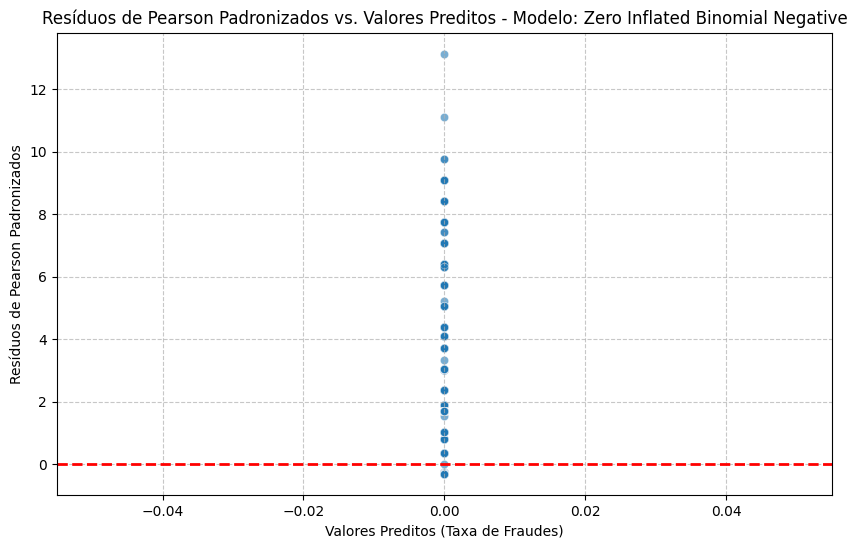

In [186]:
overdisp_plot(modelo_zinb_simples, 'Zero Inflated Binomial Negative')

In [187]:
vuong_test(modelo_binomialneg_simples, modelo_zinb_simples)

Optimization terminated successfully.
         Current function value: 0.676089
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 8
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: 23.002
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [188]:
X1 = X_scaler.copy(deep=True)
X1 = sm.add_constant(X1)

In [189]:
modelo_zinb_complete = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, inflation='probit').fit(disp=False, cov_type='HC1')
modelo_zinb_complete.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                28722
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    28673
Method:                                      MLE   Df Model:                           48
Date:                           Thu, 05 Jun 2025   Pseudo R-squ.:                  0.2415
Time:                                   22:18:26   Log-Likelihood:                -15927.
converged:                                 False   LL-Null:                       -20998.
Covariance Type:                             HC1   LLR p-value:                     0.000
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
inflate_const                                       0.4040      0.033     12.353      0.000       0.340       0.468
inflate_total_amount                               -0.2936      0.046     -6.392      0.000      -0.384      -0.204
inflate_mean_amount                                 0.0608      0.061      0.990      0.322      -0.060       0.181
inflate_max_amount                                  0.0084      0.019      0.431      0.667      -0.030       0.046
inflate_mean_current_age                           -0.0359      0.029     -1.229      0.219      -0.093       0.021
inflate_max_current_age                             0.1525      0.028      5.494      0.000       0.098       0.207
inflate_min_current_age                            -0.1773      0.029     -6.080      0.000      -0.234      -0.120
inflate_mean_per_capita_income                     -0.1189      0.034     -3.458      0.001      -0.186      -0.051
inflate_max_per_capita_income                       0.0994      0.025      3.996      0.000       0.051       0.148
inflate_min_per_capita_income                       0.0116      0.025      0.464      0.643      -0.037       0.061
inflate_mean_total_debt                             0.0599      0.026      2.273      0.023       0.008       0.112
inflate_max_total_debt                              0.0207      0.023      0.910      0.363      -0.024       0.065
inflate_min_total_debt                             -0.0484      0.044     -1.094      0.274      -0.135       0.038
inflate_mean_credit_score                           0.1156      0.024      4.774      0.000       0.068       0.163
inflate_max_credit_score                            0.0363      0.033      1.097      0.272      -0.029       0.101
inflate_min_credit_score                            0.0768      0.028      2.696      0.007       0.021       0.133
inflate_mean_num_credit_cards                      -0.0442      0.025     -1.737      0.082      -0.094       0.006
inflate_max_num_credit_cards                        0.0164      0.020      0.833      0.405      -0.022       0.055
inflate_min_num_credit_cards                       -0.0137      0.033     -0.414      0.679      -0.079       0.051
inflate_mean_credit_limit                          -0.0032      0.032     -0.101      0.919      -0.066       0.060
inflate_max_credit_limit                            0.0060      0.022      0.272      0.785      -0.037       0.050
inflate_use_chip_swipe_transaction                  0.1386      0.025      5.561      0.000       0.090       0.187
inflate_gender_female                              -0.0582      0.023     -2.488      0.013      -0.104      -0.012
inflate_card_brand_amex                             0.0333      0.024      1.401      0.161      -0.013       0.080
inflate_ca

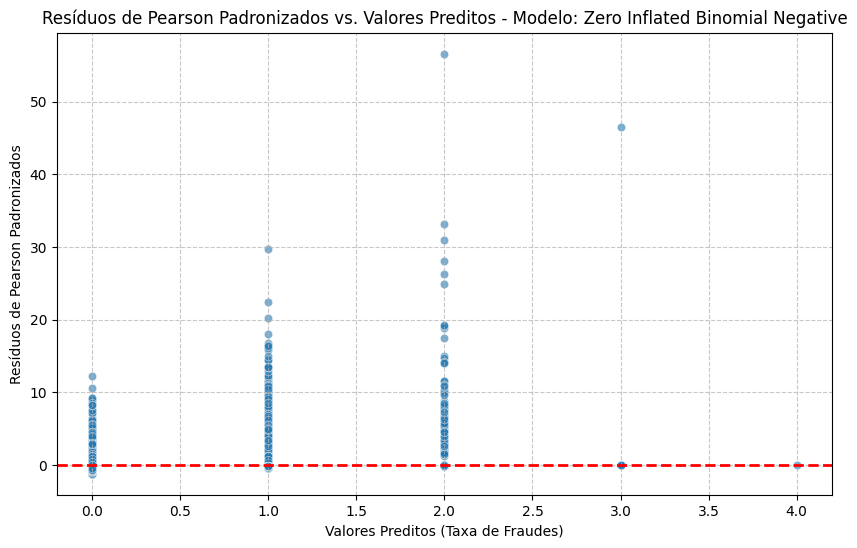

In [190]:
overdisp_plot(modelo_zinb_complete, 'Zero Inflated Binomial Negative')

In [191]:
df_features_zinp_complete = modelo_zinb_complete.pvalues.where(lambda x: x < 0.05).dropna().reset_index().rename(columns={'index':'Features', 0:'P-Value'})
feature_exog = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('~Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas')
print(feature_exog)
feature_exog_inflate = list(filter(lambda x: x not in ['const', 'alpha'], df_features_zinp_complete.query('Features.str.contains("inflate_")')['Features'].apply(lambda x: str(x).replace('inflate_','')).to_list()))
print('Exogenas Inflado')
print(feature_exog_inflate)

Exogenas
['total_amount', 'mean_amount', 'mean_current_age', 'max_current_age', 'max_per_capita_income', 'min_credit_score', 'mean_num_credit_cards', 'use_chip_swipe_transaction', 'gender_female', 'card_brand_mastercard', 'card_brand_discover', 'card_type_debit_prepaid', 'has_chip_yes', 'online_sales_no', 'category_government_utilities', 'category_transportation_logistics', 'category_retail_specialty', 'category_professional_business_services', 'category_retail_home_garden', 'category_personal_services', 'previous_frauds']
Exogenas Inflado
['total_amount', 'max_current_age', 'min_current_age', 'mean_per_capita_income', 'max_per_capita_income', 'mean_total_debt', 'mean_credit_score', 'min_credit_score', 'use_chip_swipe_transaction', 'gender_female', 'card_type_debit', 'category_retail_clothing_accessories', 'category_arts_entertainment_recreation', 'previous_frauds']


In [192]:
X1 = X_scaler[feature_exog].copy()
X1 = sm.add_constant(X1)

X2 = X_scaler[feature_exog_inflate].copy()
X2 = sm.add_constant(X2)

modelo_zinb_complete_filter = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2, inflation='probit').fit(disp=False, cov_type='HC1')
modelo_zinb_complete_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                28722
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    28700
Method:                                      MLE   Df Model:                           21
Date:                           Thu, 05 Jun 2025   Pseudo R-squ.:                  0.2379
Time:                                   22:19:35   Log-Likelihood:                -16001.
converged:                                 False   LL-Null:                       -20998.
Covariance Type:                             HC1   LLR p-value:                     0.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
inflate_const                                      0.4333      0.028     15.570      0.000       0.379       0.488
inflate_total_amount                              -0.2682      0.031     -8.618      0.000      -0.329      -0.207
inflate_max_current_age                            0.1537      0.025      6.092      0.000       0.104       0.203
inflate_min_current_age                           -0.1932      0.026     -7.573      0.000      -0.243      -0.143
inflate_mean_per_capita_income                    -0.1257      0.024     -5.169      0.000      -0.173      -0.078
inflate_max_per_capita_income                      0.1240      0.023      5.308      0.000       0.078       0.170
inflate_mean_total_debt                            0.0710      0.020      3.483      0.000       0.031       0.111
inflate_mean_credit_score                          0.1412      0.021      6.752      0.000       0.100       0.182
inflate_min_credit_score                           0.0821      0.027      3.011      0.003       0.029       0.136
inflate_use_chip_swipe_transaction                 0.1455      0.023      6.347      0.000       0.101       0.190
inflate_gender_female                             -0.0408      0.022     -1.823      0.068      -0.085       0.003
inflate_card_type_debit                            0.1035      0.019      5.368      0.000       0.066       0.141
inflate_category_retail_clothing_accessories      -0.0521      0.017     -3.034      0.002      -0.086      -0.018
inflate_category_arts_entertainment_recreation     0.3013      0.030      9.964      0.000       0.242       0.361
inflate_previous_frauds                           -1.5534      0.056    -27.798      0.000      -1.663      -1.444
const                                             -0.3484      0.041     -8.501      0.000      -0.429      -0.268
total_amount                                       1.0651      0.037     29.118      0.000       0.993       1.137
mean_amount                                       -0.8019      0.047    -17.083      0.000      -0.894      -0.710
mean_current_age                                   0.0681      0.024      2.793      0.005       0.020       0.116
max_current_age                                   -0.1042      0.028     -3.753      0.000      -0.159      -0.050
max_per_capita_income                             -0.0697      0.019     -3.705      0.000      -0.107      -0.033
min_credit_score                                   0.2003      0.037      5.379      0.000       0.127       0.273
mean_num_credit_cards                              0.0722      0.024      2.998      0.003       0.025       0.119
use_chip_swipe_transaction                        -0.0393      0.018     -2.186      0.029      -0.075      -0.004
gender_female                        

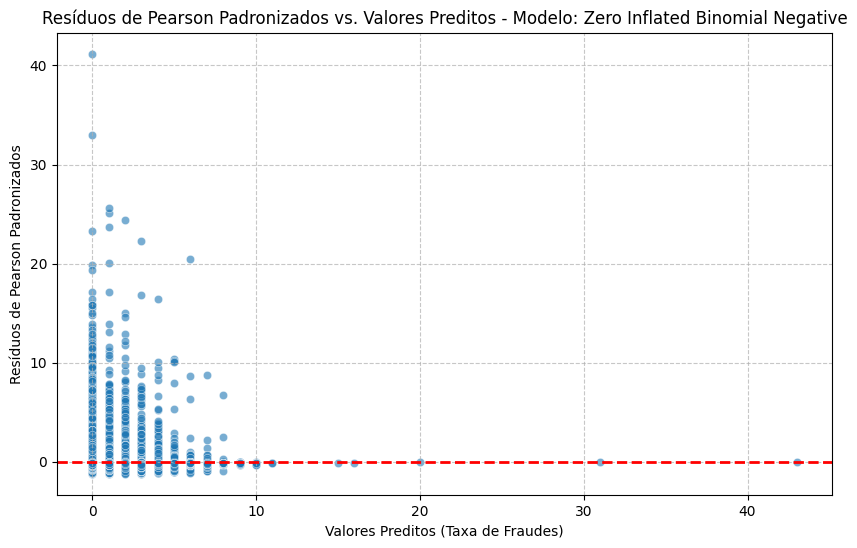

In [193]:
overdisp_plot(modelo_zinb_complete_filter, 'Zero Inflated Binomial Negative')

In [224]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='BIC',
    verbose=False,
    validation_steps=False,
    model_params=dict(inflation='probit'),
    fit_params=dict(disp=False, cov_type='HC1'),
    batch_size=8,
    tolerance=10e-6,
    early_stopping=True,
    parallel_features=True,
    n_jobs=4,
    suppress_warnings='all')
step_wise.fit(X_scaler, y)

Stepwise Selection:   0%|          | 0/100 [00:00<?, ?iter/s]

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7e1c0afa7e70>
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-

StepwiseZeroInflated(batch_size=8,
                     fit_params={'cov_type': 'HC1', 'disp': False},
                     model_params={'inflation': 'probit'}, model_type='ZINB',
                     n_jobs=4, parallel_features=True,
                     selection_criterion='BIC', tolerance=1e-05,
                     validation_steps=False)

In [225]:
modelo_zinb_stepwise = step_wise.final_model_
modelo_zinb_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                28722
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                    28712
Method:                                      MLE   Df Model:                            9
Date:                           Fri, 06 Jun 2025   Pseudo R-squ.:                  0.2212
Time:                                   10:22:33   Log-Likelihood:                -16353.
converged:                                 False   LL-Null:                       -20998.
Covariance Type:                             HC1   LLR p-value:                     0.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
inflate_const                                      0.5060      0.096      5.273      0.000       0.318       0.694
inflate_previous_frauds                           -1.5370      0.219     -7.011      0.000      -1.967      -1.107
inflate_mean_amount                                0.1862      0.037      5.030      0.000       0.114       0.259
inflate_category_arts_entertainment_recreation     0.2737      0.029      9.320      0.000       0.216       0.331
inflate_max_current_age                            0.1903      0.022      8.469      0.000       0.146       0.234
inflate_category_retail_specialty                  0.0467      0.020      2.369      0.018       0.008       0.085
inflate_card_type_debit_prepaid                   -0.0894      0.021     -4.268      0.000      -0.130      -0.048
inflate_min_credit_score                           0.1536      0.023      6.543      0.000       0.108       0.200
inflate_mean_current_age                          -0.0848      0.019     -4.537      0.000      -0.121      -0.048
const                                             -0.0595      0.025     -2.346      0.019      -0.109      -0.010
total_amount                                       0.9731      0.028     34.213      0.000       0.917       1.029
mean_amount                                       -0.4001      0.038    -10.423      0.000      -0.475      -0.325
max_current_age                                   -0.0737      0.027     -2.722      0.006      -0.127      -0.021
category_retail_specialty                          0.1622      0.024      6.649      0.000       0.114       0.210
card_type_debit_prepaid                            0.0670      0.021      3.262      0.001       0.027       0.107
min_credit_score                                   0.2192      0.034      6.480      0.000       0.153       0.285
gender_female                                      0.1232      0.021      5.856      0.000       0.082       0.164
max_per_capita_income                             -0.0815      0.018     -4.439      0.000      -0.118      -0.046
category_personal_services                        -0.0568      0.016     -3.456      0.001      -0.089      -0.025
alpha                                              0.5736      0.025     22.990      0.000       0.525       0.622
==================================================================================================================
"""

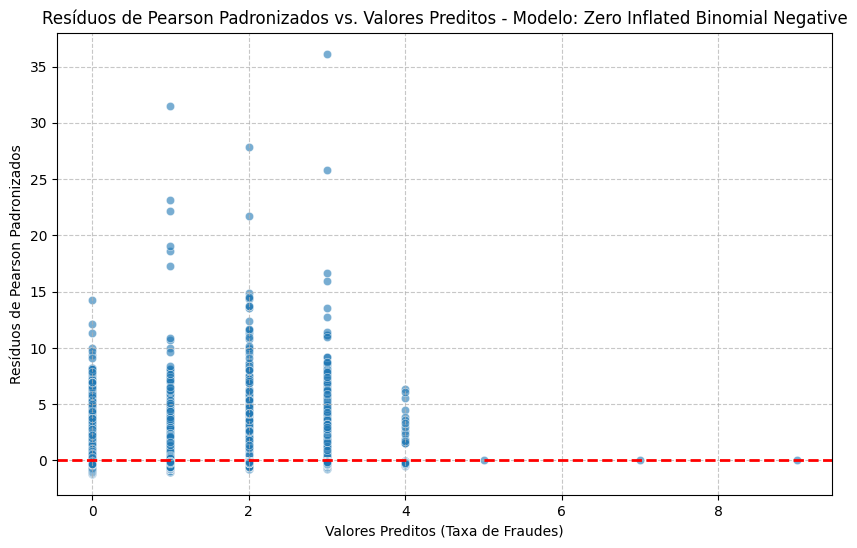

In [226]:
overdisp_plot(modelo_zinb_stepwise, 'Zero Inflated Binomial Negative')

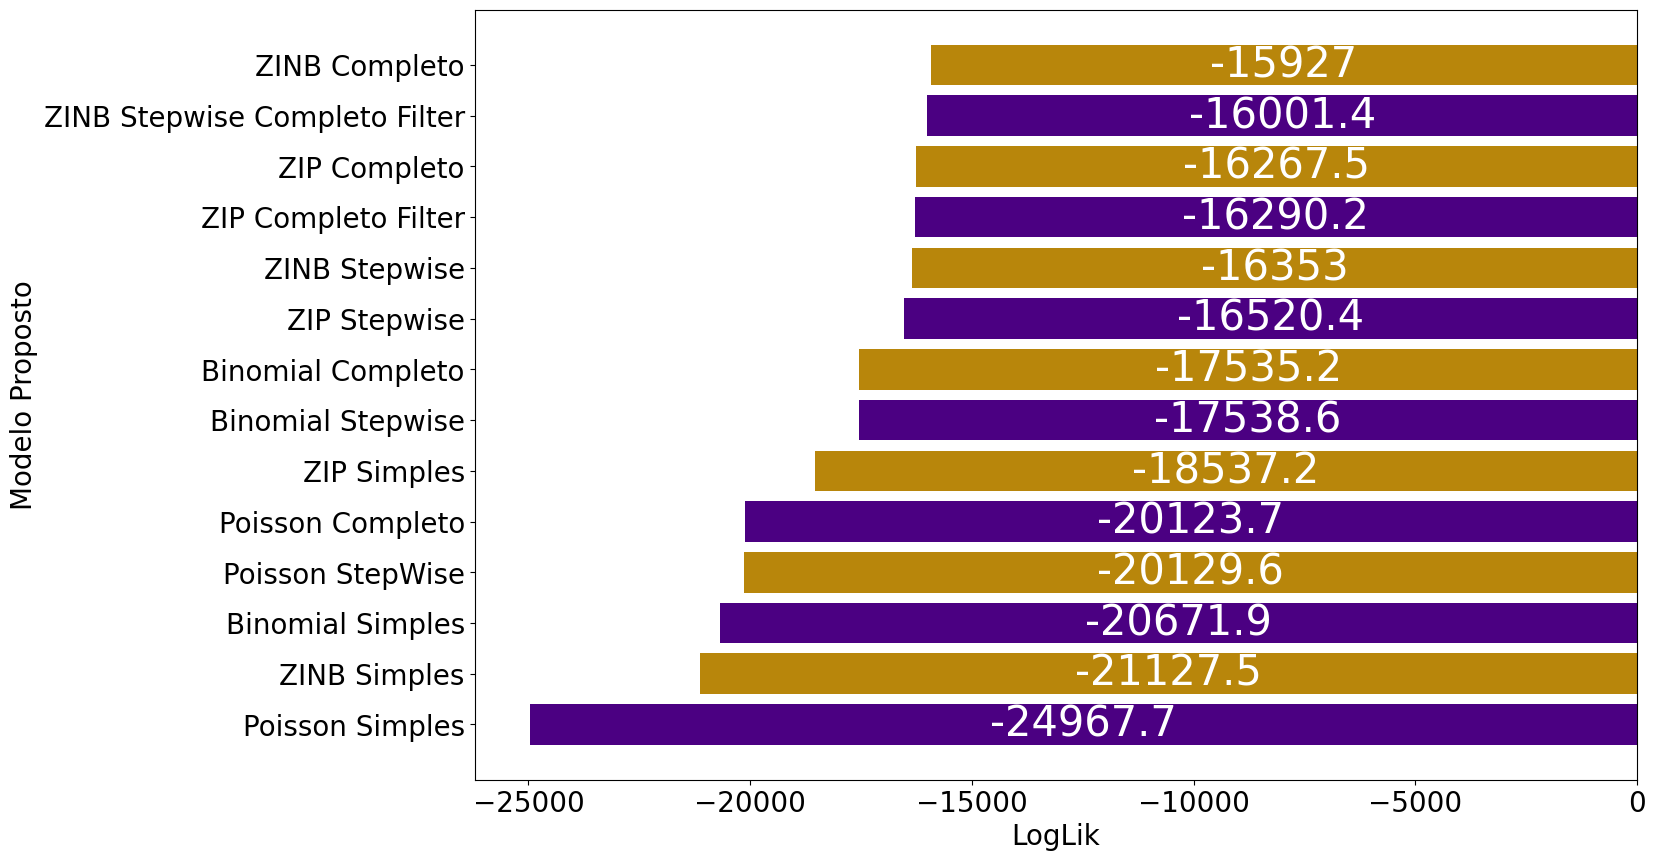

In [227]:
compare_models({
    'modelo':[
        'Poisson Simples',
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Simples',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Simples',
        'ZIP Completo',
        'ZIP Completo Filter',
        'ZIP Stepwise',
        'ZINB Simples',
        'ZINB Completo',
        'ZINB Stepwise Completo Filter',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poison_simple.llf,
        modelo_poison_complete.llf,
        modelo_poisson_stepswise.llf,
        modelo_binomialneg_simples.llf,
        modelo_binomialneg_completo.llf,
        modelo_binomialneg_stepwise.llf,
        modelo_zip_simples.llf,
        modelo_zip_complete.llf,
        modelo_zip_complete_filter.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb_simples.llf,
        modelo_zinb_complete.llf,
        modelo_zinb_complete_filter.llf,
        modelo_zinb_stepwise.llf
      ]
})

In [228]:
titles = [
  'Poisson Simples',
  'Poisson Completo',
  'Poisson StepWise',
  'Binomial Simples',
  'Binomial Completo',
  'Binomial Stepwise',
  'ZIP Simples',
  'ZIP Completo',
  'ZIP Completo Filter',
  'ZIP Stepwise',
  'ZIMB Simples',
  'ZIMB Completo',
  'ZIMB Completo Filter',
  'ZIMB Stepwise',
]
models = [
    modelo_poison_simple,
    modelo_poison_complete,
    modelo_poisson_stepswise,
    modelo_binomialneg_simples,
    modelo_binomialneg_completo,
    modelo_binomialneg_stepwise,
    modelo_zip_simples,
    modelo_zip_complete,
    modelo_zip_complete_filter,
    modelo_zip_stepwise,
    modelo_zinb_simples,
    modelo_zinb_complete,
    modelo_zinb_complete_filter,
    modelo_zinb_stepwise
]

In [229]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic)

  if np.isnan(model.llf):
    continue

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()

  metrics.append(metric)

In [242]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by='BIC')

,title,LLF,BIC,AIC,PseudoR2
5,Binomial Stepwise,-17538.591402,-277854.398192,35145.182804,0.433432
4,Binomial Completo,-17535.197089,-277707.205538,35168.394178,0.433566
3,Binomial Simples,-20671.852944,-271916.368506,41347.705887,0.295298
2,Poisson StepWise,-20129.603473,-266647.850313,40329.206946,0.593049
1,Poisson Completo,-20123.661337,-266516.018725,40345.322673,0.593218
0,Poisson Simples,-24967.692147,-257310.431781,49939.384294,0.430030
12,ZIMB Completo Filter,-16001.353169,32392.792247,32078.706338,0.237943
11,ZIMB Completo,-15927.001883,32870.280213,32052.003766,0.241484
13,ZIMB Stepwise,-16352.962731,32911.233835,32745.925462,0.221198
8,ZIP Completo Filter,-16290.161925,33001.206015,32662.323850,0.252830


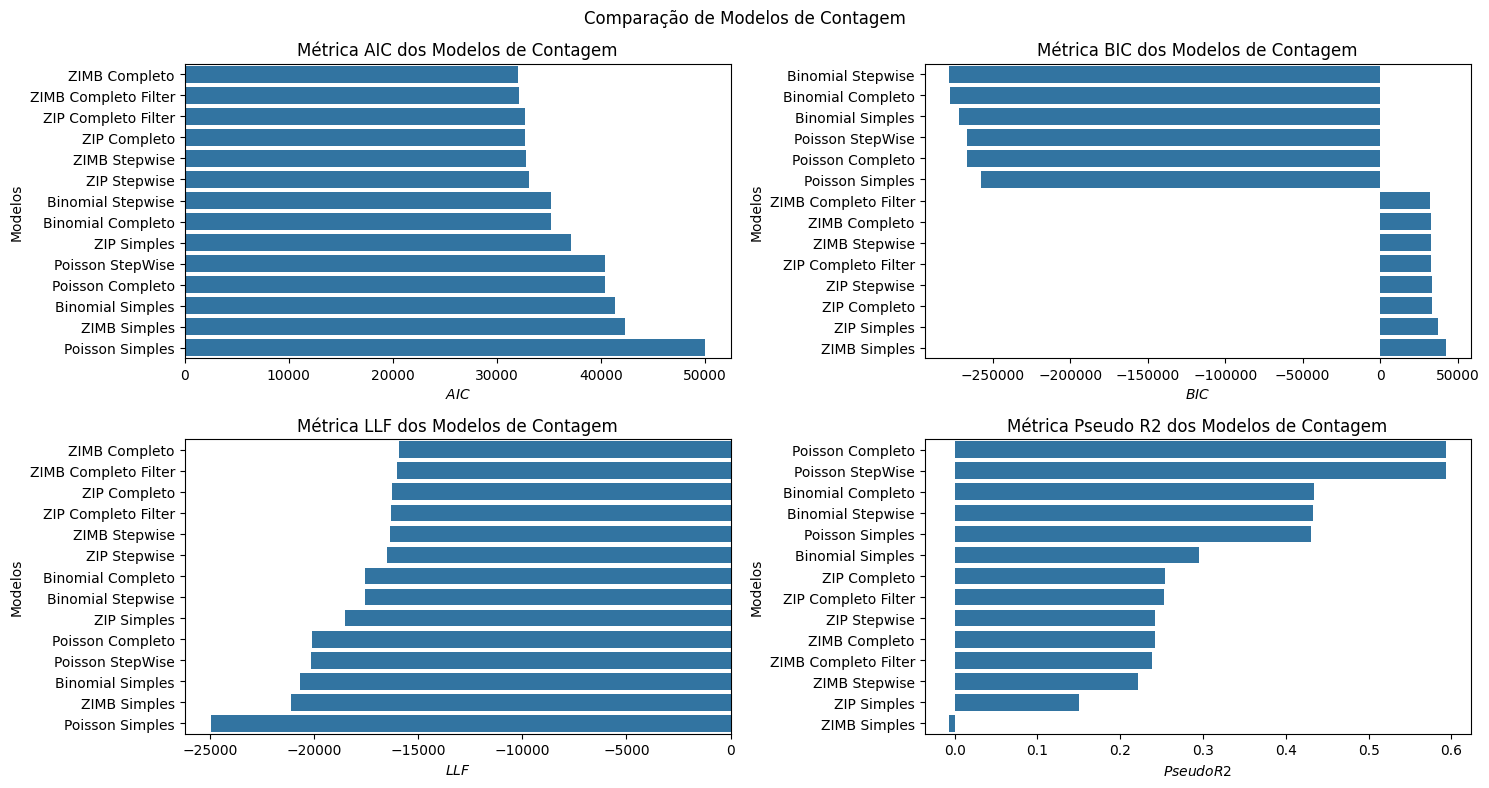

In [231]:
plt.figure(figsize=(15,8))
plt.suptitle('Comparação de Modelos de Contagem')

plt.subplot(2,2,1)
plt.title('Métrica AIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(by=['AIC', 'title'], ascending=True), y='title', x='AIC')
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,2)
plt.title('Métrica BIC dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['BIC', 'title'], ascending=True), y='title', x='BIC')
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

plt.subplot(2,2,3)
plt.title('Métrica LLF dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['LLF', 'title'], ascending=False), y='title', x='LLF')
plt.xlabel('$LLF$')
plt.ylabel('Modelos')

plt.subplot(2,2,4)
plt.title('Métrica Pseudo R2 dos Modelos de Contagem')
sns.barplot(data=df_metrics.sort_values(['PseudoR2', 'title'], ascending=False), y='title', x='PseudoR2')
plt.xlabel('$Pseudo R2$')
plt.ylabel('Modelos')

plt.tight_layout()
plt.show()

In [232]:
metrics_titles = []
metrics_mse = []
metrics_rmse = []

In [233]:
for title, model in zip(titles, models):

    if np.isnan(model.llf):
      continue

    metrics_titles.append(title)
    metrics_mse.append(mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))
    metrics_rmse.append(root_mean_squared_error(y.loc[model.fittedvalues.index], round(model.fittedvalues)))

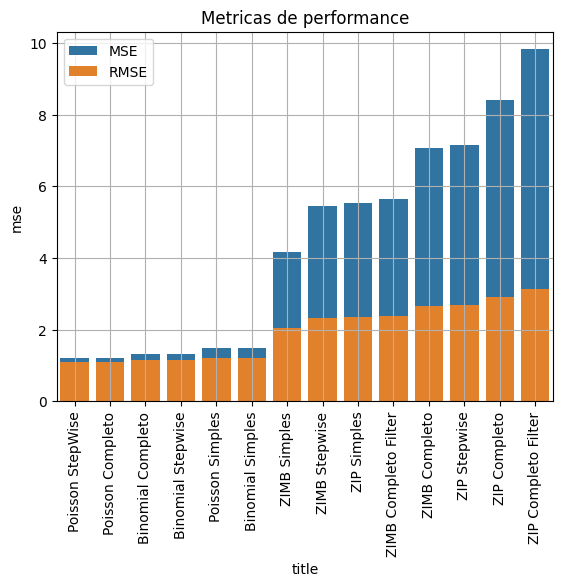

In [234]:
df_metrics = pd.DataFrame({'title':metrics_titles, 'mse':metrics_mse, 'rmse':metrics_rmse}).sort_values(by='rmse')

plt.title('Metricas de performance')
sns.barplot(data=df_metrics, x='title', y='mse', label='MSE')
sns.barplot(data=df_metrics, x='title', y='rmse', label='RMSE')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()

In [235]:
df_predict_models = pd.concat([model.fittedvalues for model in models], axis=1)
df_predict_models.columns = titles

for column in df_predict_models.columns:
  df_predict_models[column] = df_predict_models[column].apply(lambda x: 0 if np.isnan(x) or int(round(x))< 0 else int(round(x)))

df_predict_models['Target'] = y
df_predict_models.head()

,Poisson Simples,Poisson Completo,Poisson StepWise,Binomial Simples,Binomial Completo,Binomial Stepwise,ZIP Simples,ZIP Completo,ZIP Completo Filter,ZIP Stepwise,ZIMB Simples,ZIMB Completo,ZIMB Completo Filter,ZIMB Stepwise,Target
0,0,0,0,0,0,0,2,3,7,4,0,1,2,3,0
1,0,0,0,0,0,0,2,1,6,5,0,1,1,3,0
2,0,0,0,0,0,0,2,3,3,3,0,1,4,1,0
3,0,0,0,0,0,0,2,1,3,3,0,0,0,0,0
4,0,0,0,0,0,0,2,2,2,1,0,1,3,0,0


In [236]:
df_resume = df_predict_models['Target'].value_counts().reset_index()
df_resume.columns = ['Target', 'Quantidade']
df_resume = df_resume.sort_values(by='Target').reset_index(drop=True)
df_resume.head()

,Target,Quantidade
0,0,24129
1,1,1651
2,2,1032
3,3,661
4,4,456


In [237]:
resumes = [df_resume]
for column in titles:
  df_resume = df_predict_models.assign(ok=lambda x: x['Target'] == x[column]).groupby('Target').agg({'ok':'sum'}).reset_index()
  df_resume.columns = ['Target', column]
  df_resume.drop(columns='Target', inplace=True)
  resumes.append(df_resume)
df_resume = pd.concat(resumes, axis=1)

In [238]:
df_resume

,Target,Quantidade,Poisson Simples,Poisson Completo,Poisson StepWise,Binomial Simples,Binomial Completo,Binomial Stepwise,ZIP Simples,ZIP Completo,ZIP Completo Filter,ZIP Stepwise,ZIMB Simples,ZIMB Completo,ZIMB Completo Filter,ZIMB Stepwise
0,0,24129,22340,21769,21776,22340,21841,21851,1789,1836,3961,2542,24129,3036,13851,12036
1,1,1651,0,486,484,0,475,466,0,270,366,448,0,654,361,170
2,2,1032,635,187,182,635,176,179,397,191,160,291,0,14,159,25
3,3,661,0,77,79,0,73,71,0,22,30,104,0,0,66,14
4,4,456,0,46,44,0,42,46,0,1,4,25,0,0,28,0
5,5,275,0,12,13,0,14,17,0,0,1,1,0,0,3,0
6,6,204,0,4,5,0,10,10,0,0,0,0,0,0,0,0
7,7,136,0,2,2,0,4,4,0,0,0,0,0,0,0,0
8,8,52,0,0,0,0,2,2,0,0,0,0,0,0,0,0
9,9,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [239]:
df_resume_percent = df_resume.copy()
for column in titles:
  df_resume_percent[column] = round(df_resume_percent[column] / df_resume_percent['Quantidade'], 2)
df_resume_percent

,Target,Quantidade,Poisson Simples,Poisson Completo,Poisson StepWise,Binomial Simples,Binomial Completo,Binomial Stepwise,ZIP Simples,ZIP Completo,ZIP Completo Filter,ZIP Stepwise,ZIMB Simples,ZIMB Completo,ZIMB Completo Filter,ZIMB Stepwise
0,0,24129,0.93,0.90,0.90,0.93,0.91,0.91,0.07,0.08,0.16,0.11,1.0,0.13,0.57,0.50
1,1,1651,0.00,0.29,0.29,0.00,0.29,0.28,0.00,0.16,0.22,0.27,0.0,0.40,0.22,0.10
2,2,1032,0.62,0.18,0.18,0.62,0.17,0.17,0.38,0.19,0.16,0.28,0.0,0.01,0.15,0.02
3,3,661,0.00,0.12,0.12,0.00,0.11,0.11,0.00,0.03,0.05,0.16,0.0,0.00,0.10,0.02
4,4,456,0.00,0.10,0.10,0.00,0.09,0.10,0.00,0.00,0.01,0.05,0.0,0.00,0.06,0.00
5,5,275,0.00,0.04,0.05,0.00,0.05,0.06,0.00,0.00,0.00,0.00,0.0,0.00,0.01,0.00
6,6,204,0.00,0.02,0.02,0.00,0.05,0.05,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
7,7,136,0.00,0.01,0.01,0.00,0.03,0.03,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
8,8,52,0.00,0.00,0.00,0.00,0.04,0.04,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
9,9,45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00


In [240]:
df_score = df_resume_percent[titles].apply(lambda x: (len([1 for xi in x if xi > 0])/len(x)) * x.sum(), axis=0).sort_values(ascending=False)
df_score

,0
Binomial Stepwise,0.875000
Binomial Completo,0.870000
Poisson StepWise,0.742222
Poisson Completo,0.737778
ZIMB Completo Filter,0.370000
ZIP Stepwise,0.241667
Poisson Simples,0.172222
Binomial Simples,0.172222
ZIP Completo Filter,0.166667
ZIMB Stepwise,0.142222


In [241]:
model_score_name = df_score.index[0]
best_model = models[titles.index(model_score_name)]
best_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Generalized linear model
================================================================================================
Model:                         GLM                        AIC:                      35145.1828  
Link Function:                 Log                        BIC:                      -277854.3982
Dependent Variable:            frauds                     Log-Likelihood:           -17539.     
Date:                          2025-06-06 10:22           LL-Null:                  -25698.     
No. Observations:              28722                      Deviance:                 16640.      
Df Model:                      33                         Pearson chi2:             5.94e+04    
Df Residuals:                  28688                      Scale:                    1.0000      
Method:                        IRLS                                                             
------------------------------------------------------------------------------------------------
                                              Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
------------------------------------------------------------------------------------------------
Intercept                                     21.3100   2.8214   7.5531 0.0000  15.7802  26.8398
Q('total_amount')                              0.0002   0.0000  41.0947 0.0000   0.0002   0.0002
Q('mean_amount')                              -0.0586   0.0029 -20.2848 0.0000  -0.0643  -0.0530
Q('mean_current_age')                          0.0519   0.0169   3.0720 0.0021   0.0188   0.0850
Q('max_current_age')                          -0.0584   0.0050 -11.7531 0.0000  -0.0681  -0.0486
Q('min_current_age')                           0.0982   0.0115   8.5555 0.0000   0.0757   0.1206
Q('mean_per_capita_income')                    0.0001   0.0000   3.7266 0.0002   0.0000   0.0001
Q('max_per_capita_income')                    -0.0000   0.0000  -7.5074 0.0000  -0.0000  -0.0000
Q('mean_credit_score')                        -0.0274   0.0037  -7.3795 0.0000  -0.0347  -0.0201
Q('min_credit_score')                          0.0033   0.0011   2.8778 0.0040   0.0010   0.0055
Q('mean_num_credit_cards')                     0.9581   0.1753   5.4640 0.0000   0.6144   1.3017
Q('use_chip_swipe_transaction')               -0.7021   0.0578 -12.1529 0.0000  -0.8154  -0.5889
Q('gender_female')                             3.7559   0.4503   8.3411 0.0000   2.8733   4.6384
Q('card_brand_amex')                          -2.7653   1.0401  -2.6587 0.0078  -4.8040  -0.7267
Q('card_brand_mastercard')                     2.5998   0.5030   5.1689 0.0000   1.6140   3.5856
Q('card_brand_discover')                       6.8448   1.4367   4.7642 0.0000   4.0289   9.6606
Q('card_type_debit')                          -3.8137   0.5688  -6.7053 0.0000  -4.9284  -2.6989
Q('card_type_debit_prepaid')                   3.5563   0.9428   3.7721 0.0002   1.7085   5.4042
Q('online_sales_no')                         -12.4479   0.7099 -17.5344 0.0000 -13.8392 -11.0565
Q('category_government_utilities')            -4.3055   1.2817  -3.3592 0.0008  -6.8175  -1.7934
Q('category_retail_general_department')        1.8700   0.8552   2.1866 0.0288   0.1938   3.5461
Q('category_transportation_logistics')        -5.6307   0.7461  -7.5467 0.0000  -7.0930  -4.1683
Q('category_retail_clothing_accessories')     10.0770   2.1134   4.7681 0.0000   5.9348  14.2193
Q('category_retail_specialty')                 9.5591   1.2673   7.5429 0.0000   7.0752  12.0429
Q('category_arts_entertainment_recreation')   -7.8055   1.1067  -7.0530 0.0000  -9.9745  -5.6364
Q('category_professional_business_services')  -9.8184   2.0891  -4.6998 0.0000 -13.9130  -5.7239
Q('category_food_beverage')                    2.1519   0.6326   3.4015 0.0007   0.9120   3.3918
Q('category_technology_telecommunications')   -2.6223   1.1699  -2.2414 0.0250  -4.9153  -0.3293
Q('cat